# YOLO NAS Training - UAV

## Necessary Setup and Imports

In [1]:
# One time installation.
!pip install super-gradients

## RESTART RUNTIME AFTER INSTALLATION IF RUNNING ON COLAB.

In [2]:
from super_gradients.training import Trainer
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train, 
    coco_detection_yolo_format_val
)
from super_gradients.training import models
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import (
    DetectionMetrics_050,
    DetectionMetrics_050_095
)
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback
from tqdm.auto import tqdm

import os
import requests
import zipfile
import cv2
import matplotlib.pyplot as plt
import glob
import numpy as np
import random

[2023-05-11 03:47:26] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /root/sg_logs/console.log


[2023-05-11 03:47:31] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-05-11 03:47:31] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-05-11 03:47:31] WARNING - export.py - Failed to import pytorch_quantization
[2023-05-11 03:47:31] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization


## Download Dataset

In [3]:
# Download dataset.
def download_file(url, save_name):
    if not os.path.exists(save_name):
        print(f"Downloading file")
        file = requests.get(url, stream=True)
        total_size = int(file.headers.get('content-length', 0))
        block_size = 1024
        progress_bar = tqdm(
            total=total_size, 
            unit='iB', 
            unit_scale=True
        )
        with open(os.path.join(save_name), 'wb') as f:
            for data in file.iter_content(block_size):
                progress_bar.update(len(data))
                f.write(data)
        progress_bar.close()
    else:
        print('File already present')
        
download_file(
    'https://www.dropbox.com/s/xc2890eh8ujy3cu/hituav-a-highaltitude-infrared-thermal-dataset.zip?dl=1',
    'hituav-a-highaltitude-infrared-thermal-dataset.zip'
)

In [4]:
# Unzip the data file
def unzip(zip_file=None):
    try:
        with zipfile.ZipFile(zip_file) as z:
            z.extractall("./")
            print("Extracted all")
    except:
        print("Invalid file")

unzip('hituav-a-highaltitude-infrared-thermal-dataset.zip')

File already present


## Dataset Set Up

In [5]:
ROOT_DIR = 'hit-uav'
train_imgs_dir = 'images/train'
train_labels_dir = 'labels/train'
val_imgs_dir = 'images/val'
val_labels_dir = 'labels/val'
test_imgs_dir = 'images/test'
test_labels_dir = 'labels/test'
classes = ['Person', 'Car', 'Bicycle', 'OtherVechicle', 'DontCare']

In [6]:
dataset_params = {
    'data_dir':ROOT_DIR,
    'train_images_dir':train_imgs_dir,
    'train_labels_dir':train_labels_dir,
    'val_images_dir':val_imgs_dir,
    'val_labels_dir':val_labels_dir,
    'test_images_dir':test_imgs_dir,
    'test_labels_dir':test_labels_dir,
    'classes':classes 
}

In [7]:
# Global parameters.
EPOCHS = 100
BATCH_SIZE = 16
WORKERS = 8

## Visualize Ground Truth Images

In [8]:
colors = np.random.uniform(0, 255, size=(len(classes), 3))

In [9]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [10]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    height, width, _ = image.shape
    lw = max(round(sum(image.shape) / 2 * 0.003), 2)  # Line width.
    tf = max(lw - 1, 1) # Font thickness.
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # denormalize the coordinates
        xmin = int(x1*width)
        ymin = int(y1*height)
        xmax = int(x2*width)
        ymax = int(y2*height)

        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))
        
        class_name = classes[int(labels[box_num])]

        color=colors[classes.index(class_name)]
        
        cv2.rectangle(
            image, 
            p1, p2,
            color=color, 
            thickness=lw,
            lineType=cv2.LINE_AA
        ) 

        # For filled rectangle.
        w, h = cv2.getTextSize(
            class_name, 
            0, 
            fontScale=lw / 3, 
            thickness=tf
        )[0]

        outside = p1[1] - h >= 3
        p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3

        cv2.rectangle(
            image, 
            p1, p2, 
            color=color, 
            thickness=-1, 
            lineType=cv2.LINE_AA
        )  
        cv2.putText(
            image, 
            class_name, 
            (p1[0], p1[1] - 5 if outside else p1[1] + h + 2),
            cv2.FONT_HERSHEY_SIMPLEX, 
            fontScale=lw/3.5, 
            color=(255, 255, 255), 
            thickness=tf, 
            lineType=cv2.LINE_AA
        )
    return image

In [11]:
# Function to plot images with the bounding boxes.
def plot(image_path, label_path, num_samples):
    all_training_images = glob.glob(image_path+'/*')
    all_training_labels = glob.glob(label_path+'/*')
    all_training_images.sort()
    all_training_labels.sort()
    
    temp = list(zip(all_training_images, all_training_labels))
    random.shuffle(temp)
    all_training_images, all_training_labels = zip(*temp)
    all_training_images, all_training_labels = list(all_training_images), list(all_training_labels)
    
    num_images = len(all_training_images)
    
    if num_samples == -1:
        num_samples = num_images
        
    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        image_name = all_training_images[i].split(os.path.sep)[-1]
        image = cv2.imread(all_training_images[i])
        with open(all_training_labels[i], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label, x_c, y_c, w, h = label_line.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1) # Visualize 2x2 grid of images.
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

Extracted all


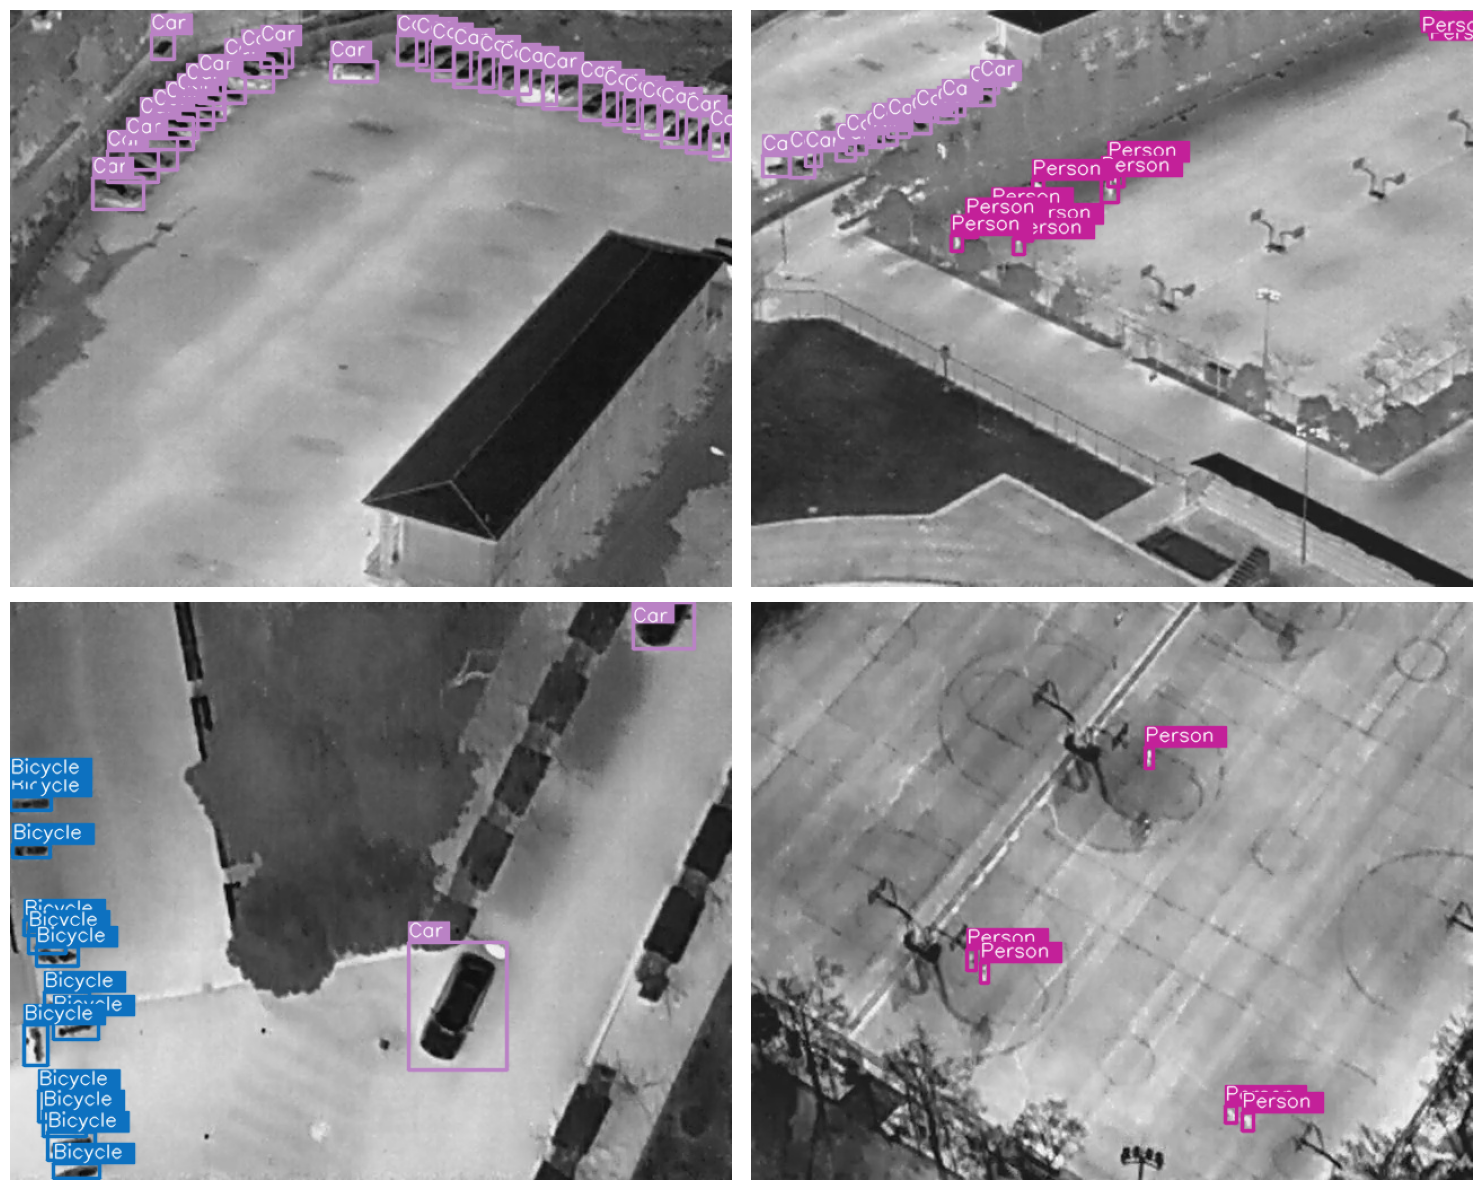

In [12]:
# Visualize a few training images.
plot(
    image_path=os.path.join(ROOT_DIR, train_imgs_dir), 
    label_path=os.path.join(ROOT_DIR, train_labels_dir),
    num_samples=4,
)

## Data Preparation

In [13]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':BATCH_SIZE,
        'num_workers':WORKERS
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':BATCH_SIZE,
        'num_workers':WORKERS
    }
)

Caching annotations: 100%|██████████| 2008/2008 [00:00<00:00, 2878.36it/s]


## Transforms and Augmentations

In [14]:
train_data.dataset.transforms

[DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': [640, 640], 'enable_mosaic': True, 'border_value': 114),
 DetectionRandomAffine('additional_samples_count': 0, 'non_empty_targets': False, 'degrees': 10.0, 'translate': 0.1, 'scale': [0.1, 2], 'shear': 2.0, 'target_size': [640, 640], 'enable': True, 'filter_box_candidates': True, 'wh_thr': 2, 'ar_thr': 20, 'area_thr': 0.1, 'border_value': 114),
 DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': [640, 640], 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114),
 DetectionHSV('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 1.0, 'hgain': 5, 'sgain': 30, 'vgain': 30, 'bgr_channels': (0, 1, 2), '_additional_channels_warned': False),
 DetectionHorizontalFlip('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 0.5, 'max_targets': 120),
 DetectionPaddedRescale('swap': (2, 0, 1),

In [15]:
train_data.dataset.transforms[0]

Caching annotations: 100%|██████████| 287/287 [00:00<00:00, 2896.10it/s]


DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': [640, 640], 'enable_mosaic': True, 'border_value': 114)

In [16]:
############ An example on how to modify augmentations ###########
train_data.dataset.transforms.pop(2)

DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': [640, 640], 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114)

In [17]:
train_data.dataset.transforms

[DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': [640, 640], 'enable_mosaic': True, 'border_value': 114),
 DetectionRandomAffine('additional_samples_count': 0, 'non_empty_targets': False, 'degrees': 10.0, 'translate': 0.1, 'scale': [0.1, 2], 'shear': 2.0, 'target_size': [640, 640], 'enable': True, 'filter_box_candidates': True, 'wh_thr': 2, 'ar_thr': 20, 'area_thr': 0.1, 'border_value': 114),
 DetectionHSV('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 1.0, 'hgain': 5, 'sgain': 30, 'vgain': 30, 'bgr_channels': (0, 1, 2), '_additional_channels_warned': False),
 DetectionHorizontalFlip('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 0.5, 'max_targets': 120),
 DetectionPaddedRescale('swap': (2, 0, 1), 'input_dim': [640, 640], 'max_targets': 120, 'pad_value': 114),
 DetectionTargetsFormatTransform('additional_samples_count': 0, 'non_empty_targets': False, 'input_format': OrderedDict([('bboxes', name

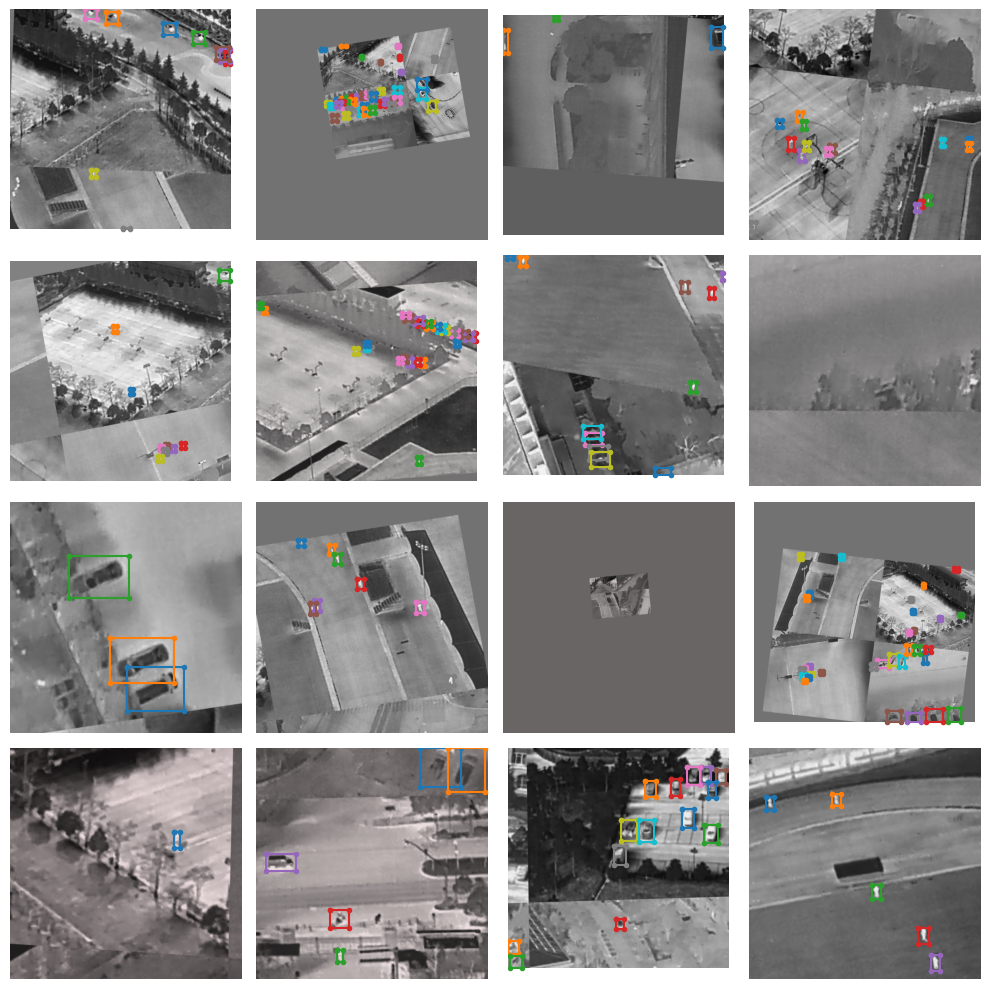

In [18]:
# We visualize the images without augmentation here.
train_data.dataset.plot(plot_transformed_data=True)

## Prepare Model and Training Parameters

In [19]:
train_params = {
    'silent_mode': False,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": EPOCHS,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        ),
        DetectionMetrics_050_095(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50:0.95'
}

In [20]:
models_to_train = [
    'yolo_nas_l'
]

In [21]:
CHECKPOINT_DIR = 'checkpoints'

### Model Training

In [22]:
for model_to_train in models_to_train:
    trainer = Trainer(
        experiment_name=model_to_train+'_'+str(EPOCHS)+'e', 
        ckpt_root_dir=CHECKPOINT_DIR
    )

    model = models.get(
        model_to_train, 
        num_classes=len(dataset_params['classes']), 
        pretrained_weights="coco"
    )

    trainer.train(
        model=model, 
        training_params=train_params, 
        train_loader=train_data, 
        valid_loader=val_data
    )

[2023-05-11 03:47:42] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
[2023-05-11 03:47:44] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}


The console stream is now moved to checkpoints/yolo_nas_l_100e/console_May11_03_47_44.txt


[2023-05-11 03:47:46] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Dataset size:                 2008       (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         125        (len(train_loader))
    - Gradient updates per epoch:   125        (len(train_loader) / batch_accumulate)

[2023-05-11 03:47:46] INFO - sg_trainer.py - Started training for 100 epochs (0/99)

Validation epoch 0: 100%|██████████| 18/18 [00:06<00:00,  2.85it/s]


SUMMARY OF EPOCH 0
├── Training
│   ├── Ppyoloeloss/loss = 3.6023
│   ├── Ppyoloeloss/loss_cls = 2.2616
│   ├── Ppyoloeloss/loss_dfl = 1.0824
│   └── Ppyoloeloss/loss_iou = 0.3198
└── Validation
    ├── F1@0.50 = 0.0
    ├── F1@0.50:0.95 = 0.0
    ├── Map@0.50 = 0.0042
    ├── Map@0.50:0.95 = 0.0017
    ├── Ppyoloeloss/loss = 3.5221
    ├── Ppyoloeloss/loss_cls = 2.374
    ├── Ppyoloeloss/loss_dfl = 0.9183
    ├── Ppyoloeloss/loss_iou = 0.2756
    ├── Precision@0.50 = 0.0
    ├── Precision@0.50:0.95 = 0.0
    ├── Recall@0.50 = 0.0
    └── Recall@0.50:0.95 = 0.0



[2023-05-11 03:49:08] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_l_100e/ckpt_best.pth
[2023-05-11 03:49:08] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.0016759874997660518
Validation epoch 1: 100%|██████████| 18/18 [00:09<00:00,  1.87it/s]


SUMMARY OF EPOCH 1
├── Training
│   ├── Ppyoloeloss/loss = 2.0522
│   │   ├── Best until now = 3.6023 (↘ -1.5501)
│   │   └── Epoch N-1      = 3.6023 (↘ -1.5501)
│   ├── Ppyoloeloss/loss_cls = 1.0541
│   │   ├── Best until now = 2.2616 (↘ -1.2076)
│   │   └── Epoch N-1      = 2.2616 (↘ -1.2076)
│   ├── Ppyoloeloss/loss_dfl = 0.8201
│   │   ├── Best until now = 1.0824 (↘ -0.2623)
│   │   └── Epoch N-1      = 1.0824 (↘ -0.2623)
│   └── Ppyoloeloss/loss_iou = 0.2352
│       ├── Best until now = 0.3198 (↘ -0.0845)
│       └── Epoch N-1      = 0.3198 (↘ -0.0845)
└── Validation
    ├── F1@0.50 = 0.0837
    │   ├── Best until now = 0.0    (↗ 0.0837)
    │   └── Epoch N-1      = 0.0    (↗ 0.0837)
    ├── F1@0.50:0.95 = 0.048
    │   ├── Best until now = 0.0    (↗ 0.048)
    │   └── Epoch N-1      = 0.0    (↗ 0.048)
    ├── Map@0.50 = 0.4083
    │   ├── Best until now = 0.0042 (↗ 0.4041)
    │   └── Epoch N-1      = 0.0042 (↗ 0.4041)
    ├── Map@0.50:0.95 = 0.2064
    │   ├── Best until now = 0

[2023-05-11 03:51:00] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_l_100e/ckpt_best.pth
[2023-05-11 03:51:00] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.2063988894224167
Validation epoch 2: 100%|██████████| 18/18 [00:09<00:00,  1.89it/s]


SUMMARY OF EPOCH 2
├── Training
│   ├── Ppyoloeloss/loss = 1.887
│   │   ├── Best until now = 2.0522 (↘ -0.1652)
│   │   └── Epoch N-1      = 2.0522 (↘ -0.1652)
│   ├── Ppyoloeloss/loss_cls = 0.9232
│   │   ├── Best until now = 1.0541 (↘ -0.1309)
│   │   └── Epoch N-1      = 1.0541 (↘ -0.1309)
│   ├── Ppyoloeloss/loss_dfl = 0.8134
│   │   ├── Best until now = 0.8201 (↘ -0.0067)
│   │   └── Epoch N-1      = 0.8201 (↘ -0.0067)
│   └── Ppyoloeloss/loss_iou = 0.2229
│       ├── Best until now = 0.2352 (↘ -0.0124)
│       └── Epoch N-1      = 0.2352 (↘ -0.0124)
└── Validation
    ├── F1@0.50 = 0.1173
    │   ├── Best until now = 0.0837 (↗ 0.0336)
    │   └── Epoch N-1      = 0.0837 (↗ 0.0336)
    ├── F1@0.50:0.95 = 0.0655
    │   ├── Best until now = 0.048  (↗ 0.0175)
    │   └── Epoch N-1      = 0.048  (↗ 0.0175)
    ├── Map@0.50 = 0.4382
    │   ├── Best until now = 0.4083 (↗ 0.0299)
    │   └── Epoch N-1      = 0.4083 (↗ 0.0299)
    ├── Map@0.50:0.95 = 0.2175
    │   ├── Best until now =

[2023-05-11 03:53:08] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_l_100e/ckpt_best.pth
[2023-05-11 03:53:08] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.21747975051403046
Validation epoch 3: 100%|██████████| 18/18 [00:09<00:00,  1.96it/s]


SUMMARY OF EPOCH 3
├── Training
│   ├── Ppyoloeloss/loss = 1.8834
│   │   ├── Best until now = 1.887  (↘ -0.0036)
│   │   └── Epoch N-1      = 1.887  (↘ -0.0036)
│   ├── Ppyoloeloss/loss_cls = 0.9109
│   │   ├── Best until now = 0.9232 (↘ -0.0123)
│   │   └── Epoch N-1      = 0.9232 (↘ -0.0123)
│   ├── Ppyoloeloss/loss_dfl = 0.8253
│   │   ├── Best until now = 0.8134 (↗ 0.0119)
│   │   └── Epoch N-1      = 0.8134 (↗ 0.0119)
│   └── Ppyoloeloss/loss_iou = 0.224
│       ├── Best until now = 0.2229 (↗ 0.0011)
│       └── Epoch N-1      = 0.2229 (↗ 0.0011)
└── Validation
    ├── F1@0.50 = 0.0793
    │   ├── Best until now = 0.1173 (↘ -0.038)
    │   └── Epoch N-1      = 0.1173 (↘ -0.038)
    ├── F1@0.50:0.95 = 0.0424
    │   ├── Best until now = 0.0655 (↘ -0.0231)
    │   └── Epoch N-1      = 0.0655 (↘ -0.0231)
    ├── Map@0.50 = 0.43
    │   ├── Best until now = 0.4382 (↘ -0.0083)
    │   └── Epoch N-1      = 0.4382 (↘ -0.0083)
    ├── Map@0.50:0.95 = 0.2026
    │   ├── Best until now = 0

Validation epoch 4: 100%|██████████| 18/18 [00:09<00:00,  1.81it/s]


SUMMARY OF EPOCH 4
├── Training
│   ├── Ppyoloeloss/loss = 1.834
│   │   ├── Best until now = 1.8834 (↘ -0.0494)
│   │   └── Epoch N-1      = 1.8834 (↘ -0.0494)
│   ├── Ppyoloeloss/loss_cls = 0.8793
│   │   ├── Best until now = 0.9109 (↘ -0.0316)
│   │   └── Epoch N-1      = 0.9109 (↘ -0.0316)
│   ├── Ppyoloeloss/loss_dfl = 0.8051
│   │   ├── Best until now = 0.8134 (↘ -0.0083)
│   │   └── Epoch N-1      = 0.8253 (↘ -0.0203)
│   └── Ppyoloeloss/loss_iou = 0.2209
│       ├── Best until now = 0.2229 (↘ -0.002)
│       └── Epoch N-1      = 0.224  (↘ -0.0031)
└── Validation
    ├── F1@0.50 = 0.142
    │   ├── Best until now = 0.1173 (↗ 0.0246)
    │   └── Epoch N-1      = 0.0793 (↗ 0.0627)
    ├── F1@0.50:0.95 = 0.0743
    │   ├── Best until now = 0.0655 (↗ 0.0088)
    │   └── Epoch N-1      = 0.0424 (↗ 0.0319)
    ├── Map@0.50 = 0.4738
    │   ├── Best until now = 0.4382 (↗ 0.0356)
    │   └── Epoch N-1      = 0.43   (↗ 0.0438)
    ├── Map@0.50:0.95 = 0.2402
    │   ├── Best until now = 0

[2023-05-11 03:57:08] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_l_100e/ckpt_best.pth
[2023-05-11 03:57:08] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.24015964567661285
Validation epoch 5: 100%|██████████| 18/18 [00:09<00:00,  1.93it/s]


SUMMARY OF EPOCH 5
├── Training
│   ├── Ppyoloeloss/loss = 1.8059
│   │   ├── Best until now = 1.834  (↘ -0.0281)
│   │   └── Epoch N-1      = 1.834  (↘ -0.0281)
│   ├── Ppyoloeloss/loss_cls = 0.8769
│   │   ├── Best until now = 0.8793 (↘ -0.0024)
│   │   └── Epoch N-1      = 0.8793 (↘ -0.0024)
│   ├── Ppyoloeloss/loss_dfl = 0.7873
│   │   ├── Best until now = 0.8051 (↘ -0.0178)
│   │   └── Epoch N-1      = 0.8051 (↘ -0.0178)
│   └── Ppyoloeloss/loss_iou = 0.2142
│       ├── Best until now = 0.2209 (↘ -0.0067)
│       └── Epoch N-1      = 0.2209 (↘ -0.0067)
└── Validation
    ├── F1@0.50 = 0.1199
    │   ├── Best until now = 0.142  (↘ -0.0221)
    │   └── Epoch N-1      = 0.142  (↘ -0.0221)
    ├── F1@0.50:0.95 = 0.0728
    │   ├── Best until now = 0.0743 (↘ -0.0015)
    │   └── Epoch N-1      = 0.0743 (↘ -0.0015)
    ├── Map@0.50 = 0.4955
    │   ├── Best until now = 0.4738 (↗ 0.0217)
    │   └── Epoch N-1      = 0.4738 (↗ 0.0217)
    ├── Map@0.50:0.95 = 0.2578
    │   ├── Best until 

[2023-05-11 03:59:48] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_l_100e/ckpt_best.pth
[2023-05-11 03:59:48] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.25784218311309814
Validation epoch 6: 100%|██████████| 18/18 [00:09<00:00,  1.82it/s]


SUMMARY OF EPOCH 6
├── Training
│   ├── Ppyoloeloss/loss = 1.7965
│   │   ├── Best until now = 1.8059 (↘ -0.0095)
│   │   └── Epoch N-1      = 1.8059 (↘ -0.0095)
│   ├── Ppyoloeloss/loss_cls = 0.87
│   │   ├── Best until now = 0.8769 (↘ -0.0069)
│   │   └── Epoch N-1      = 0.8769 (↘ -0.0069)
│   ├── Ppyoloeloss/loss_dfl = 0.7854
│   │   ├── Best until now = 0.7873 (↘ -0.0019)
│   │   └── Epoch N-1      = 0.7873 (↘ -0.0019)
│   └── Ppyoloeloss/loss_iou = 0.2135
│       ├── Best until now = 0.2142 (↘ -0.0007)
│       └── Epoch N-1      = 0.2142 (↘ -0.0007)
└── Validation
    ├── F1@0.50 = 0.1113
    │   ├── Best until now = 0.142  (↘ -0.0307)
    │   └── Epoch N-1      = 0.1199 (↘ -0.0086)
    ├── F1@0.50:0.95 = 0.0648
    │   ├── Best until now = 0.0743 (↘ -0.0095)
    │   └── Epoch N-1      = 0.0728 (↘ -0.0081)
    ├── Map@0.50 = 0.384
    │   ├── Best until now = 0.4955 (↘ -0.1115)
    │   └── Epoch N-1      = 0.4955 (↘ -0.1115)
    ├── Map@0.50:0.95 = 0.2025
    │   ├── Best until n

Validation epoch 7: 100%|██████████| 18/18 [00:09<00:00,  1.84it/s]


SUMMARY OF EPOCH 7
├── Training
│   ├── Ppyoloeloss/loss = 1.7626
│   │   ├── Best until now = 1.7965 (↘ -0.0338)
│   │   └── Epoch N-1      = 1.7965 (↘ -0.0338)
│   ├── Ppyoloeloss/loss_cls = 0.8383
│   │   ├── Best until now = 0.87   (↘ -0.0317)
│   │   └── Epoch N-1      = 0.87   (↘ -0.0317)
│   ├── Ppyoloeloss/loss_dfl = 0.7836
│   │   ├── Best until now = 0.7854 (↘ -0.0018)
│   │   └── Epoch N-1      = 0.7854 (↘ -0.0018)
│   └── Ppyoloeloss/loss_iou = 0.213
│       ├── Best until now = 0.2135 (↘ -0.0005)
│       └── Epoch N-1      = 0.2135 (↘ -0.0005)
└── Validation
    ├── F1@0.50 = 0.1105
    │   ├── Best until now = 0.142  (↘ -0.0315)
    │   └── Epoch N-1      = 0.1113 (↘ -0.0008)
    ├── F1@0.50:0.95 = 0.0643
    │   ├── Best until now = 0.0743 (↘ -0.01)
    │   └── Epoch N-1      = 0.0648 (↘ -0.0005)
    ├── Map@0.50 = 0.5573
    │   ├── Best until now = 0.4955 (↗ 0.0618)
    │   └── Epoch N-1      = 0.384  (↗ 0.1733)
    ├── Map@0.50:0.95 = 0.2701
    │   ├── Best until now

[2023-05-11 04:04:27] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_l_100e/ckpt_best.pth
[2023-05-11 04:04:27] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.2700832486152649
Validation epoch 8: 100%|██████████| 18/18 [00:09<00:00,  1.97it/s]


SUMMARY OF EPOCH 8
├── Training
│   ├── Ppyoloeloss/loss = 1.7368
│   │   ├── Best until now = 1.7626 (↘ -0.0258)
│   │   └── Epoch N-1      = 1.7626 (↘ -0.0258)
│   ├── Ppyoloeloss/loss_cls = 0.8296
│   │   ├── Best until now = 0.8383 (↘ -0.0087)
│   │   └── Epoch N-1      = 0.8383 (↘ -0.0087)
│   ├── Ppyoloeloss/loss_dfl = 0.7692
│   │   ├── Best until now = 0.7836 (↘ -0.0144)
│   │   └── Epoch N-1      = 0.7836 (↘ -0.0144)
│   └── Ppyoloeloss/loss_iou = 0.209
│       ├── Best until now = 0.213  (↘ -0.004)
│       └── Epoch N-1      = 0.213  (↘ -0.004)
└── Validation
    ├── F1@0.50 = 0.1473
    │   ├── Best until now = 0.142  (↗ 0.0053)
    │   └── Epoch N-1      = 0.1105 (↗ 0.0368)
    ├── F1@0.50:0.95 = 0.0818
    │   ├── Best until now = 0.0743 (↗ 0.0076)
    │   └── Epoch N-1      = 0.0643 (↗ 0.0176)
    ├── Map@0.50 = 0.565
    │   ├── Best until now = 0.5573 (↗ 0.0077)
    │   └── Epoch N-1      = 0.5573 (↗ 0.0077)
    ├── Map@0.50:0.95 = 0.2662
    │   ├── Best until now = 0.

Validation epoch 9: 100%|██████████| 18/18 [00:09<00:00,  1.92it/s]


SUMMARY OF EPOCH 9
├── Training
│   ├── Ppyoloeloss/loss = 1.7323
│   │   ├── Best until now = 1.7368 (↘ -0.0044)
│   │   └── Epoch N-1      = 1.7368 (↘ -0.0044)
│   ├── Ppyoloeloss/loss_cls = 0.8301
│   │   ├── Best until now = 0.8296 (↗ 0.0005)
│   │   └── Epoch N-1      = 0.8296 (↗ 0.0005)
│   ├── Ppyoloeloss/loss_dfl = 0.7685
│   │   ├── Best until now = 0.7692 (↘ -0.0007)
│   │   └── Epoch N-1      = 0.7692 (↘ -0.0007)
│   └── Ppyoloeloss/loss_iou = 0.2072
│       ├── Best until now = 0.209  (↘ -0.0019)
│       └── Epoch N-1      = 0.209  (↘ -0.0019)
└── Validation
    ├── F1@0.50 = 0.1338
    │   ├── Best until now = 0.1473 (↘ -0.0134)
    │   └── Epoch N-1      = 0.1473 (↘ -0.0134)
    ├── F1@0.50:0.95 = 0.0771
    │   ├── Best until now = 0.0818 (↘ -0.0048)
    │   └── Epoch N-1      = 0.0818 (↘ -0.0048)
    ├── Map@0.50 = 0.5582
    │   ├── Best until now = 0.565  (↘ -0.0067)
    │   └── Epoch N-1      = 0.565  (↘ -0.0067)
    ├── Map@0.50:0.95 = 0.2831
    │   ├── Best until 

[2023-05-11 04:09:32] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_l_100e/ckpt_best.pth
[2023-05-11 04:09:32] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.28307902812957764
Validation epoch 10: 100%|██████████| 18/18 [00:09<00:00,  1.93it/s]


SUMMARY OF EPOCH 10
├── Training
│   ├── Ppyoloeloss/loss = 1.7097
│   │   ├── Best until now = 1.7323 (↘ -0.0226)
│   │   └── Epoch N-1      = 1.7323 (↘ -0.0226)
│   ├── Ppyoloeloss/loss_cls = 0.8133
│   │   ├── Best until now = 0.8296 (↘ -0.0163)
│   │   └── Epoch N-1      = 0.8301 (↘ -0.0168)
│   ├── Ppyoloeloss/loss_dfl = 0.7586
│   │   ├── Best until now = 0.7685 (↘ -0.0099)
│   │   └── Epoch N-1      = 0.7685 (↘ -0.0099)
│   └── Ppyoloeloss/loss_iou = 0.2068
│       ├── Best until now = 0.2072 (↘ -0.0003)
│       └── Epoch N-1      = 0.2072 (↘ -0.0003)
└── Validation
    ├── F1@0.50 = 0.1281
    │   ├── Best until now = 0.1473 (↘ -0.0192)
    │   └── Epoch N-1      = 0.1338 (↘ -0.0058)
    ├── F1@0.50:0.95 = 0.0759
    │   ├── Best until now = 0.0818 (↘ -0.0059)
    │   └── Epoch N-1      = 0.0771 (↘ -0.0012)
    ├── Map@0.50 = 0.6437
    │   ├── Best until now = 0.565  (↗ 0.0787)
    │   └── Epoch N-1      = 0.5582 (↗ 0.0854)
    ├── Map@0.50:0.95 = 0.3299
    │   ├── Best until

[2023-05-11 04:12:14] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_l_100e/ckpt_best.pth
[2023-05-11 04:12:14] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.32989978790283203
Validation epoch 11: 100%|██████████| 18/18 [00:09<00:00,  1.85it/s]


SUMMARY OF EPOCH 11
├── Training
│   ├── Ppyoloeloss/loss = 1.7166
│   │   ├── Best until now = 1.7097 (↗ 0.0069)
│   │   └── Epoch N-1      = 1.7097 (↗ 0.0069)
│   ├── Ppyoloeloss/loss_cls = 0.8211
│   │   ├── Best until now = 0.8133 (↗ 0.0079)
│   │   └── Epoch N-1      = 0.8133 (↗ 0.0079)
│   ├── Ppyoloeloss/loss_dfl = 0.7655
│   │   ├── Best until now = 0.7586 (↗ 0.0069)
│   │   └── Epoch N-1      = 0.7586 (↗ 0.0069)
│   └── Ppyoloeloss/loss_iou = 0.2051
│       ├── Best until now = 0.2068 (↘ -0.0018)
│       └── Epoch N-1      = 0.2068 (↘ -0.0018)
└── Validation
    ├── F1@0.50 = 0.1337
    │   ├── Best until now = 0.1473 (↘ -0.0136)
    │   └── Epoch N-1      = 0.1281 (↗ 0.0056)
    ├── F1@0.50:0.95 = 0.0792
    │   ├── Best until now = 0.0818 (↘ -0.0027)
    │   └── Epoch N-1      = 0.0759 (↗ 0.0032)
    ├── Map@0.50 = 0.6518
    │   ├── Best until now = 0.6437 (↗ 0.0081)
    │   └── Epoch N-1      = 0.6437 (↗ 0.0081)
    ├── Map@0.50:0.95 = 0.3509
    │   ├── Best until now = 0

[2023-05-11 04:14:59] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_l_100e/ckpt_best.pth
[2023-05-11 04:14:59] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.3509415090084076
Validation epoch 12: 100%|██████████| 18/18 [00:09<00:00,  1.94it/s]


SUMMARY OF EPOCH 12
├── Training
│   ├── Ppyoloeloss/loss = 1.701
│   │   ├── Best until now = 1.7097 (↘ -0.0087)
│   │   └── Epoch N-1      = 1.7166 (↘ -0.0156)
│   ├── Ppyoloeloss/loss_cls = 0.8137
│   │   ├── Best until now = 0.8133 (↗ 0.0005)
│   │   └── Epoch N-1      = 0.8211 (↘ -0.0074)
│   ├── Ppyoloeloss/loss_dfl = 0.7578
│   │   ├── Best until now = 0.7586 (↘ -0.0009)
│   │   └── Epoch N-1      = 0.7655 (↘ -0.0078)
│   └── Ppyoloeloss/loss_iou = 0.2034
│       ├── Best until now = 0.2051 (↘ -0.0017)
│       └── Epoch N-1      = 0.2051 (↘ -0.0017)
└── Validation
    ├── F1@0.50 = 0.136
    │   ├── Best until now = 0.1473 (↘ -0.0112)
    │   └── Epoch N-1      = 0.1337 (↗ 0.0023)
    ├── F1@0.50:0.95 = 0.0777
    │   ├── Best until now = 0.0818 (↘ -0.0041)
    │   └── Epoch N-1      = 0.0792 (↘ -0.0015)
    ├── Map@0.50 = 0.5717
    │   ├── Best until now = 0.6518 (↘ -0.0801)
    │   └── Epoch N-1      = 0.6518 (↘ -0.0801)
    ├── Map@0.50:0.95 = 0.2735
    │   ├── Best until n

Validation epoch 13: 100%|██████████| 18/18 [00:09<00:00,  1.91it/s]


SUMMARY OF EPOCH 13
├── Training
│   ├── Ppyoloeloss/loss = 1.7191
│   │   ├── Best until now = 1.701  (↗ 0.0181)
│   │   └── Epoch N-1      = 1.701  (↗ 0.0181)
│   ├── Ppyoloeloss/loss_cls = 0.8307
│   │   ├── Best until now = 0.8133 (↗ 0.0175)
│   │   └── Epoch N-1      = 0.8137 (↗ 0.017)
│   ├── Ppyoloeloss/loss_dfl = 0.7622
│   │   ├── Best until now = 0.7578 (↗ 0.0044)
│   │   └── Epoch N-1      = 0.7578 (↗ 0.0044)
│   └── Ppyoloeloss/loss_iou = 0.2029
│       ├── Best until now = 0.2034 (↘ -0.0004)
│       └── Epoch N-1      = 0.2034 (↘ -0.0004)
└── Validation
    ├── F1@0.50 = 0.1598
    │   ├── Best until now = 0.1473 (↗ 0.0125)
    │   └── Epoch N-1      = 0.136  (↗ 0.0238)
    ├── F1@0.50:0.95 = 0.0954
    │   ├── Best until now = 0.0818 (↗ 0.0136)
    │   └── Epoch N-1      = 0.0777 (↗ 0.0177)
    ├── Map@0.50 = 0.5754
    │   ├── Best until now = 0.6518 (↘ -0.0764)
    │   └── Epoch N-1      = 0.5717 (↗ 0.0037)
    ├── Map@0.50:0.95 = 0.2992
    │   ├── Best until now = 0.3

Validation epoch 14: 100%|██████████| 18/18 [00:09<00:00,  1.81it/s]


SUMMARY OF EPOCH 14
├── Training
│   ├── Ppyoloeloss/loss = 1.7065
│   │   ├── Best until now = 1.701  (↗ 0.0055)
│   │   └── Epoch N-1      = 1.7191 (↘ -0.0127)
│   ├── Ppyoloeloss/loss_cls = 0.8134
│   │   ├── Best until now = 0.8133 (↗ 1e-04)
│   │   └── Epoch N-1      = 0.8307 (↘ -0.0174)
│   ├── Ppyoloeloss/loss_dfl = 0.7649
│   │   ├── Best until now = 0.7578 (↗ 0.0072)
│   │   └── Epoch N-1      = 0.7622 (↗ 0.0027)
│   └── Ppyoloeloss/loss_iou = 0.2043
│       ├── Best until now = 0.2029 (↗ 0.0013)
│       └── Epoch N-1      = 0.2029 (↗ 0.0013)
└── Validation
    ├── F1@0.50 = 0.161
    │   ├── Best until now = 0.1598 (↗ 0.0011)
    │   └── Epoch N-1      = 0.1598 (↗ 0.0011)
    ├── F1@0.50:0.95 = 0.0946
    │   ├── Best until now = 0.0954 (↘ -0.0008)
    │   └── Epoch N-1      = 0.0954 (↘ -0.0008)
    ├── Map@0.50 = 0.6108
    │   ├── Best until now = 0.6518 (↘ -0.041)
    │   └── Epoch N-1      = 0.5754 (↗ 0.0353)
    ├── Map@0.50:0.95 = 0.325
    │   ├── Best until now = 0.35

Validation epoch 15: 100%|██████████| 18/18 [00:09<00:00,  1.94it/s]


SUMMARY OF EPOCH 15
├── Training
│   ├── Ppyoloeloss/loss = 1.7067
│   │   ├── Best until now = 1.701  (↗ 0.0056)
│   │   └── Epoch N-1      = 1.7065 (↗ 0.0002)
│   ├── Ppyoloeloss/loss_cls = 0.819
│   │   ├── Best until now = 0.8133 (↗ 0.0057)
│   │   └── Epoch N-1      = 0.8134 (↗ 0.0056)
│   ├── Ppyoloeloss/loss_dfl = 0.7562
│   │   ├── Best until now = 0.7578 (↘ -0.0015)
│   │   └── Epoch N-1      = 0.7649 (↘ -0.0087)
│   └── Ppyoloeloss/loss_iou = 0.2038
│       ├── Best until now = 0.2029 (↗ 0.0009)
│       └── Epoch N-1      = 0.2043 (↘ -0.0004)
└── Validation
    ├── F1@0.50 = 0.1292
    │   ├── Best until now = 0.161  (↘ -0.0318)
    │   └── Epoch N-1      = 0.161  (↘ -0.0318)
    ├── F1@0.50:0.95 = 0.0764
    │   ├── Best until now = 0.0954 (↘ -0.019)
    │   └── Epoch N-1      = 0.0946 (↘ -0.0181)
    ├── Map@0.50 = 0.5708
    │   ├── Best until now = 0.6518 (↘ -0.081)
    │   └── Epoch N-1      = 0.6108 (↘ -0.0399)
    ├── Map@0.50:0.95 = 0.3053
    │   ├── Best until now =

Validation epoch 16: 100%|██████████| 18/18 [00:09<00:00,  1.95it/s]


SUMMARY OF EPOCH 16
├── Training
│   ├── Ppyoloeloss/loss = 1.7159
│   │   ├── Best until now = 1.701  (↗ 0.0149)
│   │   └── Epoch N-1      = 1.7067 (↗ 0.0092)
│   ├── Ppyoloeloss/loss_cls = 0.8212
│   │   ├── Best until now = 0.8133 (↗ 0.008)
│   │   └── Epoch N-1      = 0.819  (↗ 0.0023)
│   ├── Ppyoloeloss/loss_dfl = 0.7614
│   │   ├── Best until now = 0.7562 (↗ 0.0052)
│   │   └── Epoch N-1      = 0.7562 (↗ 0.0052)
│   └── Ppyoloeloss/loss_iou = 0.2056
│       ├── Best until now = 0.2029 (↗ 0.0027)
│       └── Epoch N-1      = 0.2038 (↗ 0.0017)
└── Validation
    ├── F1@0.50 = 0.1099
    │   ├── Best until now = 0.161  (↘ -0.0511)
    │   └── Epoch N-1      = 0.1292 (↘ -0.0193)
    ├── F1@0.50:0.95 = 0.0645
    │   ├── Best until now = 0.0954 (↘ -0.0309)
    │   └── Epoch N-1      = 0.0764 (↘ -0.0119)
    ├── Map@0.50 = 0.5734
    │   ├── Best until now = 0.6518 (↘ -0.0784)
    │   └── Epoch N-1      = 0.5708 (↗ 0.0026)
    ├── Map@0.50:0.95 = 0.2861
    │   ├── Best until now = 0

Validation epoch 17: 100%|██████████| 18/18 [00:09<00:00,  1.88it/s]


SUMMARY OF EPOCH 17
├── Training
│   ├── Ppyoloeloss/loss = 1.6914
│   │   ├── Best until now = 1.701  (↘ -0.0096)
│   │   └── Epoch N-1      = 1.7159 (↘ -0.0245)
│   ├── Ppyoloeloss/loss_cls = 0.8105
│   │   ├── Best until now = 0.8133 (↘ -0.0028)
│   │   └── Epoch N-1      = 0.8212 (↘ -0.0108)
│   ├── Ppyoloeloss/loss_dfl = 0.7551
│   │   ├── Best until now = 0.7562 (↘ -0.0011)
│   │   └── Epoch N-1      = 0.7614 (↘ -0.0063)
│   └── Ppyoloeloss/loss_iou = 0.2013
│       ├── Best until now = 0.2029 (↘ -0.0016)
│       └── Epoch N-1      = 0.2056 (↘ -0.0042)
└── Validation
    ├── F1@0.50 = 0.1507
    │   ├── Best until now = 0.161  (↘ -0.0103)
    │   └── Epoch N-1      = 0.1099 (↗ 0.0408)
    ├── F1@0.50:0.95 = 0.0897
    │   ├── Best until now = 0.0954 (↘ -0.0057)
    │   └── Epoch N-1      = 0.0645 (↗ 0.0252)
    ├── Map@0.50 = 0.6577
    │   ├── Best until now = 0.6518 (↗ 0.0059)
    │   └── Epoch N-1      = 0.5734 (↗ 0.0842)
    ├── Map@0.50:0.95 = 0.3613
    │   ├── Best until n

[2023-05-11 04:30:14] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_l_100e/ckpt_best.pth
[2023-05-11 04:30:14] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.36129817366600037
Validation epoch 18: 100%|██████████| 18/18 [00:10<00:00,  1.79it/s]


SUMMARY OF EPOCH 18
├── Training
│   ├── Ppyoloeloss/loss = 1.6913
│   │   ├── Best until now = 1.6914 (↘ -0.0)
│   │   └── Epoch N-1      = 1.6914 (↘ -0.0)
│   ├── Ppyoloeloss/loss_cls = 0.8057
│   │   ├── Best until now = 0.8105 (↘ -0.0048)
│   │   └── Epoch N-1      = 0.8105 (↘ -0.0048)
│   ├── Ppyoloeloss/loss_dfl = 0.7575
│   │   ├── Best until now = 0.7551 (↗ 0.0023)
│   │   └── Epoch N-1      = 0.7551 (↗ 0.0023)
│   └── Ppyoloeloss/loss_iou = 0.2028
│       ├── Best until now = 0.2013 (↗ 0.0014)
│       └── Epoch N-1      = 0.2013 (↗ 0.0014)
└── Validation
    ├── F1@0.50 = 0.161
    │   ├── Best until now = 0.161  (↗ 0.0001)
    │   └── Epoch N-1      = 0.1507 (↗ 0.0104)
    ├── F1@0.50:0.95 = 0.0967
    │   ├── Best until now = 0.0954 (↗ 0.0013)
    │   └── Epoch N-1      = 0.0897 (↗ 0.007)
    ├── Map@0.50 = 0.6522
    │   ├── Best until now = 0.6577 (↘ -0.0055)
    │   └── Epoch N-1      = 0.6577 (↘ -0.0055)
    ├── Map@0.50:0.95 = 0.3399
    │   ├── Best until now = 0.3613 

Validation epoch 19: 100%|██████████| 18/18 [00:09<00:00,  1.85it/s]


SUMMARY OF EPOCH 19
├── Training
│   ├── Ppyoloeloss/loss = 1.6811
│   │   ├── Best until now = 1.6913 (↘ -0.0103)
│   │   └── Epoch N-1      = 1.6913 (↘ -0.0103)
│   ├── Ppyoloeloss/loss_cls = 0.8007
│   │   ├── Best until now = 0.8057 (↘ -0.005)
│   │   └── Epoch N-1      = 0.8057 (↘ -0.005)
│   ├── Ppyoloeloss/loss_dfl = 0.7512
│   │   ├── Best until now = 0.7551 (↘ -0.0039)
│   │   └── Epoch N-1      = 0.7575 (↘ -0.0063)
│   └── Ppyoloeloss/loss_iou = 0.2019
│       ├── Best until now = 0.2013 (↗ 0.0006)
│       └── Epoch N-1      = 0.2028 (↘ -0.0009)
└── Validation
    ├── F1@0.50 = 0.1515
    │   ├── Best until now = 0.161  (↘ -0.0096)
    │   └── Epoch N-1      = 0.161  (↘ -0.0096)
    ├── F1@0.50:0.95 = 0.0908
    │   ├── Best until now = 0.0967 (↘ -0.0059)
    │   └── Epoch N-1      = 0.0967 (↘ -0.0059)
    ├── Map@0.50 = 0.6615
    │   ├── Best until now = 0.6577 (↗ 0.0038)
    │   └── Epoch N-1      = 0.6522 (↗ 0.0093)
    ├── Map@0.50:0.95 = 0.3532
    │   ├── Best until no

Validation epoch 20: 100%|██████████| 18/18 [00:09<00:00,  1.90it/s]


SUMMARY OF EPOCH 20
├── Training
│   ├── Ppyoloeloss/loss = 1.6727
│   │   ├── Best until now = 1.6811 (↘ -0.0084)
│   │   └── Epoch N-1      = 1.6811 (↘ -0.0084)
│   ├── Ppyoloeloss/loss_cls = 0.8017
│   │   ├── Best until now = 0.8007 (↗ 0.001)
│   │   └── Epoch N-1      = 0.8007 (↗ 0.001)
│   ├── Ppyoloeloss/loss_dfl = 0.7491
│   │   ├── Best until now = 0.7512 (↘ -0.0022)
│   │   └── Epoch N-1      = 0.7512 (↘ -0.0022)
│   └── Ppyoloeloss/loss_iou = 0.1986
│       ├── Best until now = 0.2013 (↘ -0.0028)
│       └── Epoch N-1      = 0.2019 (↘ -0.0033)
└── Validation
    ├── F1@0.50 = 0.1451
    │   ├── Best until now = 0.161  (↘ -0.016)
    │   └── Epoch N-1      = 0.1515 (↘ -0.0064)
    ├── F1@0.50:0.95 = 0.0868
    │   ├── Best until now = 0.0967 (↘ -0.0099)
    │   └── Epoch N-1      = 0.0908 (↘ -0.004)
    ├── Map@0.50 = 0.6441
    │   ├── Best until now = 0.6615 (↘ -0.0174)
    │   └── Epoch N-1      = 0.6615 (↘ -0.0174)
    ├── Map@0.50:0.95 = 0.356
    │   ├── Best until now 

Validation epoch 21: 100%|██████████| 18/18 [00:09<00:00,  1.85it/s]


SUMMARY OF EPOCH 21
├── Training
│   ├── Ppyoloeloss/loss = 1.6768
│   │   ├── Best until now = 1.6727 (↗ 0.0041)
│   │   └── Epoch N-1      = 1.6727 (↗ 0.0041)
│   ├── Ppyoloeloss/loss_cls = 0.8062
│   │   ├── Best until now = 0.8007 (↗ 0.0054)
│   │   └── Epoch N-1      = 0.8017 (↗ 0.0044)
│   ├── Ppyoloeloss/loss_dfl = 0.7441
│   │   ├── Best until now = 0.7491 (↘ -0.005)
│   │   └── Epoch N-1      = 0.7491 (↘ -0.005)
│   └── Ppyoloeloss/loss_iou = 0.1994
│       ├── Best until now = 0.1986 (↗ 0.0009)
│       └── Epoch N-1      = 0.1986 (↗ 0.0009)
└── Validation
    ├── F1@0.50 = 0.1467
    │   ├── Best until now = 0.161  (↘ -0.0144)
    │   └── Epoch N-1      = 0.1451 (↗ 0.0016)
    ├── F1@0.50:0.95 = 0.0856
    │   ├── Best until now = 0.0967 (↘ -0.0111)
    │   └── Epoch N-1      = 0.0868 (↘ -0.0012)
    ├── Map@0.50 = 0.6153
    │   ├── Best until now = 0.6615 (↘ -0.0462)
    │   └── Epoch N-1      = 0.6441 (↘ -0.0288)
    ├── Map@0.50:0.95 = 0.3251
    │   ├── Best until now = 

Validation epoch 22: 100%|██████████| 18/18 [00:09<00:00,  1.86it/s]


SUMMARY OF EPOCH 22
├── Training
│   ├── Ppyoloeloss/loss = 1.6917
│   │   ├── Best until now = 1.6727 (↗ 0.019)
│   │   └── Epoch N-1      = 1.6768 (↗ 0.015)
│   ├── Ppyoloeloss/loss_cls = 0.8139
│   │   ├── Best until now = 0.8007 (↗ 0.0131)
│   │   └── Epoch N-1      = 0.8062 (↗ 0.0077)
│   ├── Ppyoloeloss/loss_dfl = 0.7454
│   │   ├── Best until now = 0.7441 (↗ 0.0014)
│   │   └── Epoch N-1      = 0.7441 (↗ 0.0014)
│   └── Ppyoloeloss/loss_iou = 0.2021
│       ├── Best until now = 0.1986 (↗ 0.0035)
│       └── Epoch N-1      = 0.1994 (↗ 0.0026)
└── Validation
    ├── F1@0.50 = 0.1428
    │   ├── Best until now = 0.161  (↘ -0.0182)
    │   └── Epoch N-1      = 0.1467 (↘ -0.0038)
    ├── F1@0.50:0.95 = 0.0864
    │   ├── Best until now = 0.0967 (↘ -0.0103)
    │   └── Epoch N-1      = 0.0856 (↗ 0.0008)
    ├── Map@0.50 = 0.6766
    │   ├── Best until now = 0.6615 (↗ 0.0151)
    │   └── Epoch N-1      = 0.6153 (↗ 0.0613)
    ├── Map@0.50:0.95 = 0.378
    │   ├── Best until now = 0.361

[2023-05-11 04:42:42] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_l_100e/ckpt_best.pth
[2023-05-11 04:42:42] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.3779674470424652
Validation epoch 23: 100%|██████████| 18/18 [00:09<00:00,  1.86it/s]


SUMMARY OF EPOCH 23
├── Training
│   ├── Ppyoloeloss/loss = 1.6723
│   │   ├── Best until now = 1.6727 (↘ -0.0004)
│   │   └── Epoch N-1      = 1.6917 (↘ -0.0194)
│   ├── Ppyoloeloss/loss_cls = 0.8027
│   │   ├── Best until now = 0.8007 (↗ 0.002)
│   │   └── Epoch N-1      = 0.8139 (↘ -0.0111)
│   ├── Ppyoloeloss/loss_dfl = 0.7415
│   │   ├── Best until now = 0.7441 (↘ -0.0026)
│   │   └── Epoch N-1      = 0.7454 (↘ -0.004)
│   └── Ppyoloeloss/loss_iou = 0.1995
│       ├── Best until now = 0.1986 (↗ 0.001)
│       └── Epoch N-1      = 0.2021 (↘ -0.0025)
└── Validation
    ├── F1@0.50 = 0.1524
    │   ├── Best until now = 0.161  (↘ -0.0087)
    │   └── Epoch N-1      = 0.1428 (↗ 0.0095)
    ├── F1@0.50:0.95 = 0.0892
    │   ├── Best until now = 0.0967 (↘ -0.0075)
    │   └── Epoch N-1      = 0.0864 (↗ 0.0028)
    ├── Map@0.50 = 0.6487
    │   ├── Best until now = 0.6766 (↘ -0.0279)
    │   └── Epoch N-1      = 0.6766 (↘ -0.0279)
    ├── Map@0.50:0.95 = 0.3262
    │   ├── Best until now 

Validation epoch 24: 100%|██████████| 18/18 [00:09<00:00,  1.86it/s]


SUMMARY OF EPOCH 24
├── Training
│   ├── Ppyoloeloss/loss = 1.6796
│   │   ├── Best until now = 1.6723 (↗ 0.0072)
│   │   └── Epoch N-1      = 1.6723 (↗ 0.0072)
│   ├── Ppyoloeloss/loss_cls = 0.8067
│   │   ├── Best until now = 0.8007 (↗ 0.006)
│   │   └── Epoch N-1      = 0.8027 (↗ 0.004)
│   ├── Ppyoloeloss/loss_dfl = 0.7467
│   │   ├── Best until now = 0.7415 (↗ 0.0052)
│   │   └── Epoch N-1      = 0.7415 (↗ 0.0052)
│   └── Ppyoloeloss/loss_iou = 0.1998
│       ├── Best until now = 0.1986 (↗ 0.0013)
│       └── Epoch N-1      = 0.1995 (↗ 0.0003)
└── Validation
    ├── F1@0.50 = 0.1409
    │   ├── Best until now = 0.161  (↘ -0.0201)
    │   └── Epoch N-1      = 0.1524 (↘ -0.0114)
    ├── F1@0.50:0.95 = 0.0858
    │   ├── Best until now = 0.0967 (↘ -0.0109)
    │   └── Epoch N-1      = 0.0892 (↘ -0.0034)
    ├── Map@0.50 = 0.6536
    │   ├── Best until now = 0.6766 (↘ -0.023)
    │   └── Epoch N-1      = 0.6487 (↗ 0.0049)
    ├── Map@0.50:0.95 = 0.3579
    │   ├── Best until now = 0.3

Validation epoch 25: 100%|██████████| 18/18 [00:09<00:00,  1.90it/s]


SUMMARY OF EPOCH 25
├── Training
│   ├── Ppyoloeloss/loss = 1.6797
│   │   ├── Best until now = 1.6723 (↗ 0.0074)
│   │   └── Epoch N-1      = 1.6796 (↗ 1e-04)
│   ├── Ppyoloeloss/loss_cls = 0.8069
│   │   ├── Best until now = 0.8007 (↗ 0.0062)
│   │   └── Epoch N-1      = 0.8067 (↗ 0.0002)
│   ├── Ppyoloeloss/loss_dfl = 0.7537
│   │   ├── Best until now = 0.7415 (↗ 0.0122)
│   │   └── Epoch N-1      = 0.7467 (↗ 0.007)
│   └── Ppyoloeloss/loss_iou = 0.1984
│       ├── Best until now = 0.1986 (↘ -0.0002)
│       └── Epoch N-1      = 0.1998 (↘ -0.0014)
└── Validation
    ├── F1@0.50 = 0.1255
    │   ├── Best until now = 0.161  (↘ -0.0355)
    │   └── Epoch N-1      = 0.1409 (↘ -0.0154)
    ├── F1@0.50:0.95 = 0.0734
    │   ├── Best until now = 0.0967 (↘ -0.0233)
    │   └── Epoch N-1      = 0.0858 (↘ -0.0124)
    ├── Map@0.50 = 0.5713
    │   ├── Best until now = 0.6766 (↘ -0.1053)
    │   └── Epoch N-1      = 0.6536 (↘ -0.0822)
    ├── Map@0.50:0.95 = 0.3048
    │   ├── Best until now =

Validation epoch 26: 100%|██████████| 18/18 [00:09<00:00,  1.93it/s]


SUMMARY OF EPOCH 26
├── Training
│   ├── Ppyoloeloss/loss = 1.6757
│   │   ├── Best until now = 1.6723 (↗ 0.0034)
│   │   └── Epoch N-1      = 1.6797 (↘ -0.004)
│   ├── Ppyoloeloss/loss_cls = 0.8013
│   │   ├── Best until now = 0.8007 (↗ 0.0006)
│   │   └── Epoch N-1      = 0.8069 (↘ -0.0056)
│   ├── Ppyoloeloss/loss_dfl = 0.7463
│   │   ├── Best until now = 0.7415 (↗ 0.0048)
│   │   └── Epoch N-1      = 0.7537 (↘ -0.0074)
│   └── Ppyoloeloss/loss_iou = 0.2005
│       ├── Best until now = 0.1984 (↗ 0.0021)
│       └── Epoch N-1      = 0.1984 (↗ 0.0021)
└── Validation
    ├── F1@0.50 = 0.1668
    │   ├── Best until now = 0.161  (↗ 0.0058)
    │   └── Epoch N-1      = 0.1255 (↗ 0.0413)
    ├── F1@0.50:0.95 = 0.0982
    │   ├── Best until now = 0.0967 (↗ 0.0015)
    │   └── Epoch N-1      = 0.0734 (↗ 0.0248)
    ├── Map@0.50 = 0.6811
    │   ├── Best until now = 0.6766 (↗ 0.0045)
    │   └── Epoch N-1      = 0.5713 (↗ 0.1097)
    ├── Map@0.50:0.95 = 0.3496
    │   ├── Best until now = 0.3

Validation epoch 27: 100%|██████████| 18/18 [00:10<00:00,  1.77it/s]


SUMMARY OF EPOCH 27
├── Training
│   ├── Ppyoloeloss/loss = 1.6627
│   │   ├── Best until now = 1.6723 (↘ -0.0096)
│   │   └── Epoch N-1      = 1.6757 (↘ -0.013)
│   ├── Ppyoloeloss/loss_cls = 0.7927
│   │   ├── Best until now = 0.8007 (↘ -0.008)
│   │   └── Epoch N-1      = 0.8013 (↘ -0.0086)
│   ├── Ppyoloeloss/loss_dfl = 0.7428
│   │   ├── Best until now = 0.7415 (↗ 0.0013)
│   │   └── Epoch N-1      = 0.7463 (↘ -0.0035)
│   └── Ppyoloeloss/loss_iou = 0.1994
│       ├── Best until now = 0.1984 (↗ 0.001)
│       └── Epoch N-1      = 0.2005 (↘ -0.0011)
└── Validation
    ├── F1@0.50 = 0.1435
    │   ├── Best until now = 0.1668 (↘ -0.0234)
    │   └── Epoch N-1      = 0.1668 (↘ -0.0234)
    ├── F1@0.50:0.95 = 0.0826
    │   ├── Best until now = 0.0982 (↘ -0.0156)
    │   └── Epoch N-1      = 0.0982 (↘ -0.0156)
    ├── Map@0.50 = 0.6658
    │   ├── Best until now = 0.6811 (↘ -0.0152)
    │   └── Epoch N-1      = 0.6811 (↘ -0.0152)
    ├── Map@0.50:0.95 = 0.3503
    │   ├── Best until no

Validation epoch 28: 100%|██████████| 18/18 [00:09<00:00,  1.85it/s]


SUMMARY OF EPOCH 28
├── Training
│   ├── Ppyoloeloss/loss = 1.6395
│   │   ├── Best until now = 1.6627 (↘ -0.0232)
│   │   └── Epoch N-1      = 1.6627 (↘ -0.0232)
│   ├── Ppyoloeloss/loss_cls = 0.7797
│   │   ├── Best until now = 0.7927 (↘ -0.013)
│   │   └── Epoch N-1      = 0.7927 (↘ -0.013)
│   ├── Ppyoloeloss/loss_dfl = 0.7367
│   │   ├── Best until now = 0.7415 (↘ -0.0048)
│   │   └── Epoch N-1      = 0.7428 (↘ -0.0061)
│   └── Ppyoloeloss/loss_iou = 0.1965
│       ├── Best until now = 0.1984 (↘ -0.0019)
│       └── Epoch N-1      = 0.1994 (↘ -0.0029)
└── Validation
    ├── F1@0.50 = 0.1483
    │   ├── Best until now = 0.1668 (↘ -0.0186)
    │   └── Epoch N-1      = 0.1435 (↗ 0.0048)
    ├── F1@0.50:0.95 = 0.09
    │   ├── Best until now = 0.0982 (↘ -0.0082)
    │   └── Epoch N-1      = 0.0826 (↗ 0.0074)
    ├── Map@0.50 = 0.6336
    │   ├── Best until now = 0.6811 (↘ -0.0474)
    │   └── Epoch N-1      = 0.6658 (↘ -0.0322)
    ├── Map@0.50:0.95 = 0.3422
    │   ├── Best until now

Validation epoch 29: 100%|██████████| 18/18 [00:09<00:00,  1.83it/s]


SUMMARY OF EPOCH 29
├── Training
│   ├── Ppyoloeloss/loss = 1.6285
│   │   ├── Best until now = 1.6395 (↘ -0.0109)
│   │   └── Epoch N-1      = 1.6395 (↘ -0.0109)
│   ├── Ppyoloeloss/loss_cls = 0.7707
│   │   ├── Best until now = 0.7797 (↘ -0.009)
│   │   └── Epoch N-1      = 0.7797 (↘ -0.009)
│   ├── Ppyoloeloss/loss_dfl = 0.7371
│   │   ├── Best until now = 0.7367 (↗ 0.0004)
│   │   └── Epoch N-1      = 0.7367 (↗ 0.0004)
│   └── Ppyoloeloss/loss_iou = 0.1957
│       ├── Best until now = 0.1965 (↘ -0.0008)
│       └── Epoch N-1      = 0.1965 (↘ -0.0008)
└── Validation
    ├── F1@0.50 = 0.1462
    │   ├── Best until now = 0.1668 (↘ -0.0206)
    │   └── Epoch N-1      = 0.1483 (↘ -0.0021)
    ├── F1@0.50:0.95 = 0.0871
    │   ├── Best until now = 0.0982 (↘ -0.0111)
    │   └── Epoch N-1      = 0.09   (↘ -0.0029)
    ├── Map@0.50 = 0.6287
    │   ├── Best until now = 0.6811 (↘ -0.0524)
    │   └── Epoch N-1      = 0.6336 (↘ -0.005)
    ├── Map@0.50:0.95 = 0.3266
    │   ├── Best until no

Validation epoch 30: 100%|██████████| 18/18 [00:09<00:00,  1.87it/s]


SUMMARY OF EPOCH 30
├── Training
│   ├── Ppyoloeloss/loss = 1.6429
│   │   ├── Best until now = 1.6285 (↗ 0.0144)
│   │   └── Epoch N-1      = 1.6285 (↗ 0.0144)
│   ├── Ppyoloeloss/loss_cls = 0.7797
│   │   ├── Best until now = 0.7707 (↗ 0.009)
│   │   └── Epoch N-1      = 0.7707 (↗ 0.009)
│   ├── Ppyoloeloss/loss_dfl = 0.7431
│   │   ├── Best until now = 0.7367 (↗ 0.0064)
│   │   └── Epoch N-1      = 0.7371 (↗ 0.0059)
│   └── Ppyoloeloss/loss_iou = 0.1967
│       ├── Best until now = 0.1957 (↗ 0.0009)
│       └── Epoch N-1      = 0.1957 (↗ 0.0009)
└── Validation
    ├── F1@0.50 = 0.1959
    │   ├── Best until now = 0.1668 (↗ 0.029)
    │   └── Epoch N-1      = 0.1462 (↗ 0.0497)
    ├── F1@0.50:0.95 = 0.1196
    │   ├── Best until now = 0.0982 (↗ 0.0214)
    │   └── Epoch N-1      = 0.0871 (↗ 0.0325)
    ├── Map@0.50 = 0.6259
    │   ├── Best until now = 0.6811 (↘ -0.0552)
    │   └── Epoch N-1      = 0.6287 (↘ -0.0028)
    ├── Map@0.50:0.95 = 0.3565
    │   ├── Best until now = 0.378 

Validation epoch 31: 100%|██████████| 18/18 [00:09<00:00,  1.93it/s]


SUMMARY OF EPOCH 31
├── Training
│   ├── Ppyoloeloss/loss = 1.6372
│   │   ├── Best until now = 1.6285 (↗ 0.0086)
│   │   └── Epoch N-1      = 1.6429 (↘ -0.0057)
│   ├── Ppyoloeloss/loss_cls = 0.7753
│   │   ├── Best until now = 0.7707 (↗ 0.0046)
│   │   └── Epoch N-1      = 0.7797 (↘ -0.0044)
│   ├── Ppyoloeloss/loss_dfl = 0.7439
│   │   ├── Best until now = 0.7367 (↗ 0.0072)
│   │   └── Epoch N-1      = 0.7431 (↗ 0.0008)
│   └── Ppyoloeloss/loss_iou = 0.196
│       ├── Best until now = 0.1957 (↗ 0.0003)
│       └── Epoch N-1      = 0.1967 (↘ -0.0007)
└── Validation
    ├── F1@0.50 = 0.1819
    │   ├── Best until now = 0.1959 (↘ -0.014)
    │   └── Epoch N-1      = 0.1959 (↘ -0.014)
    ├── F1@0.50:0.95 = 0.1009
    │   ├── Best until now = 0.1196 (↘ -0.0188)
    │   └── Epoch N-1      = 0.1196 (↘ -0.0188)
    ├── Map@0.50 = 0.6724
    │   ├── Best until now = 0.6811 (↘ -0.0087)
    │   └── Epoch N-1      = 0.6259 (↗ 0.0465)
    ├── Map@0.50:0.95 = 0.3317
    │   ├── Best until now = 

Validation epoch 32: 100%|██████████| 18/18 [00:09<00:00,  1.93it/s]


SUMMARY OF EPOCH 32
├── Training
│   ├── Ppyoloeloss/loss = 1.6358
│   │   ├── Best until now = 1.6285 (↗ 0.0073)
│   │   └── Epoch N-1      = 1.6372 (↘ -0.0013)
│   ├── Ppyoloeloss/loss_cls = 0.7822
│   │   ├── Best until now = 0.7707 (↗ 0.0115)
│   │   └── Epoch N-1      = 0.7753 (↗ 0.0069)
│   ├── Ppyoloeloss/loss_dfl = 0.7371
│   │   ├── Best until now = 0.7367 (↗ 0.0004)
│   │   └── Epoch N-1      = 0.7439 (↘ -0.0068)
│   └── Ppyoloeloss/loss_iou = 0.194
│       ├── Best until now = 0.1957 (↘ -0.0017)
│       └── Epoch N-1      = 0.196  (↘ -0.0019)
└── Validation
    ├── F1@0.50 = 0.1531
    │   ├── Best until now = 0.1959 (↘ -0.0427)
    │   └── Epoch N-1      = 0.1819 (↘ -0.0287)
    ├── F1@0.50:0.95 = 0.0893
    │   ├── Best until now = 0.1196 (↘ -0.0303)
    │   └── Epoch N-1      = 0.1009 (↘ -0.0116)
    ├── Map@0.50 = 0.6534
    │   ├── Best until now = 0.6811 (↘ -0.0276)
    │   └── Epoch N-1      = 0.6724 (↘ -0.019)
    ├── Map@0.50:0.95 = 0.348
    │   ├── Best until now 

Validation epoch 33: 100%|██████████| 18/18 [00:09<00:00,  1.86it/s]


SUMMARY OF EPOCH 33
├── Training
│   ├── Ppyoloeloss/loss = 1.6422
│   │   ├── Best until now = 1.6285 (↗ 0.0136)
│   │   └── Epoch N-1      = 1.6358 (↗ 0.0063)
│   ├── Ppyoloeloss/loss_cls = 0.7815
│   │   ├── Best until now = 0.7707 (↗ 0.0108)
│   │   └── Epoch N-1      = 0.7822 (↘ -0.0008)
│   ├── Ppyoloeloss/loss_dfl = 0.7413
│   │   ├── Best until now = 0.7367 (↗ 0.0046)
│   │   └── Epoch N-1      = 0.7371 (↗ 0.0042)
│   └── Ppyoloeloss/loss_iou = 0.196
│       ├── Best until now = 0.194  (↗ 0.002)
│       └── Epoch N-1      = 0.194  (↗ 0.002)
└── Validation
    ├── F1@0.50 = 0.1908
    │   ├── Best until now = 0.1959 (↘ -0.0051)
    │   └── Epoch N-1      = 0.1531 (↗ 0.0377)
    ├── F1@0.50:0.95 = 0.1076
    │   ├── Best until now = 0.1196 (↘ -0.012)
    │   └── Epoch N-1      = 0.0893 (↗ 0.0183)
    ├── Map@0.50 = 0.6714
    │   ├── Best until now = 0.6811 (↘ -0.0097)
    │   └── Epoch N-1      = 0.6534 (↗ 0.0179)
    ├── Map@0.50:0.95 = 0.3311
    │   ├── Best until now = 0.378

Validation epoch 34: 100%|██████████| 18/18 [00:10<00:00,  1.77it/s]


SUMMARY OF EPOCH 34
├── Training
│   ├── Ppyoloeloss/loss = 1.6308
│   │   ├── Best until now = 1.6285 (↗ 0.0023)
│   │   └── Epoch N-1      = 1.6422 (↘ -0.0113)
│   ├── Ppyoloeloss/loss_cls = 0.7721
│   │   ├── Best until now = 0.7707 (↗ 0.0014)
│   │   └── Epoch N-1      = 0.7815 (↘ -0.0094)
│   ├── Ppyoloeloss/loss_dfl = 0.7398
│   │   ├── Best until now = 0.7367 (↗ 0.0031)
│   │   └── Epoch N-1      = 0.7413 (↘ -0.0015)
│   └── Ppyoloeloss/loss_iou = 0.1955
│       ├── Best until now = 0.194  (↗ 0.0015)
│       └── Epoch N-1      = 0.196  (↘ -0.0005)
└── Validation
    ├── F1@0.50 = 0.1799
    │   ├── Best until now = 0.1959 (↘ -0.016)
    │   └── Epoch N-1      = 0.1908 (↘ -0.0109)
    ├── F1@0.50:0.95 = 0.1113
    │   ├── Best until now = 0.1196 (↘ -0.0083)
    │   └── Epoch N-1      = 0.1076 (↗ 0.0037)
    ├── Map@0.50 = 0.7091
    │   ├── Best until now = 0.6811 (↗ 0.028)
    │   └── Epoch N-1      = 0.6714 (↗ 0.0377)
    ├── Map@0.50:0.95 = 0.3813
    │   ├── Best until now = 

[2023-05-11 05:12:20] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_l_100e/ckpt_best.pth
[2023-05-11 05:12:20] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.3812935948371887
Validation epoch 35: 100%|██████████| 18/18 [00:09<00:00,  1.81it/s]


SUMMARY OF EPOCH 35
├── Training
│   ├── Ppyoloeloss/loss = 1.6149
│   │   ├── Best until now = 1.6285 (↘ -0.0136)
│   │   └── Epoch N-1      = 1.6308 (↘ -0.0159)
│   ├── Ppyoloeloss/loss_cls = 0.7606
│   │   ├── Best until now = 0.7707 (↘ -0.0101)
│   │   └── Epoch N-1      = 0.7721 (↘ -0.0115)
│   ├── Ppyoloeloss/loss_dfl = 0.7409
│   │   ├── Best until now = 0.7367 (↗ 0.0042)
│   │   └── Epoch N-1      = 0.7398 (↗ 0.0011)
│   └── Ppyoloeloss/loss_iou = 0.1936
│       ├── Best until now = 0.194  (↘ -0.0005)
│       └── Epoch N-1      = 0.1955 (↘ -0.002)
└── Validation
    ├── F1@0.50 = 0.1697
    │   ├── Best until now = 0.1959 (↘ -0.0262)
    │   └── Epoch N-1      = 0.1799 (↘ -0.0102)
    ├── F1@0.50:0.95 = 0.0997
    │   ├── Best until now = 0.1196 (↘ -0.0199)
    │   └── Epoch N-1      = 0.1113 (↘ -0.0116)
    ├── Map@0.50 = 0.64
    │   ├── Best until now = 0.7091 (↘ -0.0691)
    │   └── Epoch N-1      = 0.7091 (↘ -0.0691)
    ├── Map@0.50:0.95 = 0.3447
    │   ├── Best until no

Validation epoch 36: 100%|██████████| 18/18 [00:09<00:00,  1.87it/s]


SUMMARY OF EPOCH 36
├── Training
│   ├── Ppyoloeloss/loss = 1.6148
│   │   ├── Best until now = 1.6149 (↘ -1e-04)
│   │   └── Epoch N-1      = 1.6149 (↘ -1e-04)
│   ├── Ppyoloeloss/loss_cls = 0.766
│   │   ├── Best until now = 0.7606 (↗ 0.0055)
│   │   └── Epoch N-1      = 0.7606 (↗ 0.0055)
│   ├── Ppyoloeloss/loss_dfl = 0.7351
│   │   ├── Best until now = 0.7367 (↘ -0.0016)
│   │   └── Epoch N-1      = 0.7409 (↘ -0.0058)
│   └── Ppyoloeloss/loss_iou = 0.1925
│       ├── Best until now = 0.1936 (↘ -0.0011)
│       └── Epoch N-1      = 0.1936 (↘ -0.0011)
└── Validation
    ├── F1@0.50 = 0.2088
    │   ├── Best until now = 0.1959 (↗ 0.0129)
    │   └── Epoch N-1      = 0.1697 (↗ 0.0391)
    ├── F1@0.50:0.95 = 0.1251
    │   ├── Best until now = 0.1196 (↗ 0.0055)
    │   └── Epoch N-1      = 0.0997 (↗ 0.0254)
    ├── Map@0.50 = 0.6869
    │   ├── Best until now = 0.7091 (↘ -0.0222)
    │   └── Epoch N-1      = 0.64   (↗ 0.0469)
    ├── Map@0.50:0.95 = 0.3749
    │   ├── Best until now = 0

Validation epoch 37: 100%|██████████| 18/18 [00:10<00:00,  1.66it/s]


SUMMARY OF EPOCH 37
├── Training
│   ├── Ppyoloeloss/loss = 1.6215
│   │   ├── Best until now = 1.6148 (↗ 0.0066)
│   │   └── Epoch N-1      = 1.6148 (↗ 0.0066)
│   ├── Ppyoloeloss/loss_cls = 0.7688
│   │   ├── Best until now = 0.7606 (↗ 0.0082)
│   │   └── Epoch N-1      = 0.766  (↗ 0.0027)
│   ├── Ppyoloeloss/loss_dfl = 0.7344
│   │   ├── Best until now = 0.7351 (↘ -0.0008)
│   │   └── Epoch N-1      = 0.7351 (↘ -0.0008)
│   └── Ppyoloeloss/loss_iou = 0.1942
│       ├── Best until now = 0.1925 (↗ 0.0017)
│       └── Epoch N-1      = 0.1925 (↗ 0.0017)
└── Validation
    ├── F1@0.50 = 0.1636
    │   ├── Best until now = 0.2088 (↘ -0.0451)
    │   └── Epoch N-1      = 0.2088 (↘ -0.0451)
    ├── F1@0.50:0.95 = 0.0991
    │   ├── Best until now = 0.1251 (↘ -0.026)
    │   └── Epoch N-1      = 0.1251 (↘ -0.026)
    ├── Map@0.50 = 0.6023
    │   ├── Best until now = 0.7091 (↘ -0.1068)
    │   └── Epoch N-1      = 0.6869 (↘ -0.0846)
    ├── Map@0.50:0.95 = 0.3389
    │   ├── Best until now =

Validation epoch 38: 100%|██████████| 18/18 [00:09<00:00,  1.89it/s]


SUMMARY OF EPOCH 38
├── Training
│   ├── Ppyoloeloss/loss = 1.6228
│   │   ├── Best until now = 1.6148 (↗ 0.008)
│   │   └── Epoch N-1      = 1.6215 (↗ 0.0013)
│   ├── Ppyoloeloss/loss_cls = 0.7755
│   │   ├── Best until now = 0.7606 (↗ 0.015)
│   │   └── Epoch N-1      = 0.7688 (↗ 0.0067)
│   ├── Ppyoloeloss/loss_dfl = 0.7352
│   │   ├── Best until now = 0.7344 (↗ 0.0009)
│   │   └── Epoch N-1      = 0.7344 (↗ 0.0009)
│   └── Ppyoloeloss/loss_iou = 0.1919
│       ├── Best until now = 0.1925 (↘ -0.0006)
│       └── Epoch N-1      = 0.1942 (↘ -0.0023)
└── Validation
    ├── F1@0.50 = 0.2009
    │   ├── Best until now = 0.2088 (↘ -0.0079)
    │   └── Epoch N-1      = 0.1636 (↗ 0.0373)
    ├── F1@0.50:0.95 = 0.1204
    │   ├── Best until now = 0.1251 (↘ -0.0047)
    │   └── Epoch N-1      = 0.0991 (↗ 0.0213)
    ├── Map@0.50 = 0.6825
    │   ├── Best until now = 0.7091 (↘ -0.0266)
    │   └── Epoch N-1      = 0.6023 (↗ 0.0801)
    ├── Map@0.50:0.95 = 0.3722
    │   ├── Best until now = 0.

Validation epoch 39: 100%|██████████| 18/18 [00:09<00:00,  1.92it/s]


SUMMARY OF EPOCH 39
├── Training
│   ├── Ppyoloeloss/loss = 1.6137
│   │   ├── Best until now = 1.6148 (↘ -0.0011)
│   │   └── Epoch N-1      = 1.6228 (↘ -0.0091)
│   ├── Ppyoloeloss/loss_cls = 0.7669
│   │   ├── Best until now = 0.7606 (↗ 0.0063)
│   │   └── Epoch N-1      = 0.7755 (↘ -0.0087)
│   ├── Ppyoloeloss/loss_dfl = 0.7342
│   │   ├── Best until now = 0.7344 (↘ -0.0002)
│   │   └── Epoch N-1      = 0.7352 (↘ -0.0011)
│   └── Ppyoloeloss/loss_iou = 0.1919
│       ├── Best until now = 0.1919 (↗ 0.0)
│       └── Epoch N-1      = 0.1919 (↗ 0.0)
└── Validation
    ├── F1@0.50 = 0.1423
    │   ├── Best until now = 0.2088 (↘ -0.0665)
    │   └── Epoch N-1      = 0.2009 (↘ -0.0586)
    ├── F1@0.50:0.95 = 0.0854
    │   ├── Best until now = 0.1251 (↘ -0.0397)
    │   └── Epoch N-1      = 0.1204 (↘ -0.035)
    ├── Map@0.50 = 0.6408
    │   ├── Best until now = 0.7091 (↘ -0.0683)
    │   └── Epoch N-1      = 0.6825 (↘ -0.0417)
    ├── Map@0.50:0.95 = 0.345
    │   ├── Best until now = 0.

Validation epoch 40: 100%|██████████| 18/18 [00:09<00:00,  1.91it/s]


SUMMARY OF EPOCH 40
├── Training
│   ├── Ppyoloeloss/loss = 1.6232
│   │   ├── Best until now = 1.6137 (↗ 0.0095)
│   │   └── Epoch N-1      = 1.6137 (↗ 0.0095)
│   ├── Ppyoloeloss/loss_cls = 0.7745
│   │   ├── Best until now = 0.7606 (↗ 0.0139)
│   │   └── Epoch N-1      = 0.7669 (↗ 0.0076)
│   ├── Ppyoloeloss/loss_dfl = 0.7345
│   │   ├── Best until now = 0.7342 (↗ 0.0004)
│   │   └── Epoch N-1      = 0.7342 (↗ 0.0004)
│   └── Ppyoloeloss/loss_iou = 0.1926
│       ├── Best until now = 0.1919 (↗ 0.0007)
│       └── Epoch N-1      = 0.1919 (↗ 0.0007)
└── Validation
    ├── F1@0.50 = 0.1498
    │   ├── Best until now = 0.2088 (↘ -0.0589)
    │   └── Epoch N-1      = 0.1423 (↗ 0.0075)
    ├── F1@0.50:0.95 = 0.0887
    │   ├── Best until now = 0.1251 (↘ -0.0364)
    │   └── Epoch N-1      = 0.0854 (↗ 0.0033)
    ├── Map@0.50 = 0.6619
    │   ├── Best until now = 0.7091 (↘ -0.0472)
    │   └── Epoch N-1      = 0.6408 (↗ 0.0211)
    ├── Map@0.50:0.95 = 0.3603
    │   ├── Best until now = 0.

Validation epoch 41: 100%|██████████| 18/18 [00:09<00:00,  1.93it/s]


SUMMARY OF EPOCH 41
├── Training
│   ├── Ppyoloeloss/loss = 1.611
│   │   ├── Best until now = 1.6137 (↘ -0.0028)
│   │   └── Epoch N-1      = 1.6232 (↘ -0.0123)
│   ├── Ppyoloeloss/loss_cls = 0.7619
│   │   ├── Best until now = 0.7606 (↗ 0.0013)
│   │   └── Epoch N-1      = 0.7745 (↘ -0.0126)
│   ├── Ppyoloeloss/loss_dfl = 0.7352
│   │   ├── Best until now = 0.7342 (↗ 0.0011)
│   │   └── Epoch N-1      = 0.7345 (↗ 0.0007)
│   └── Ppyoloeloss/loss_iou = 0.1926
│       ├── Best until now = 0.1919 (↗ 0.0007)
│       └── Epoch N-1      = 0.1926 (↘ -0.0)
└── Validation
    ├── F1@0.50 = 0.1719
    │   ├── Best until now = 0.2088 (↘ -0.0368)
    │   └── Epoch N-1      = 0.1498 (↗ 0.0221)
    ├── F1@0.50:0.95 = 0.0972
    │   ├── Best until now = 0.1251 (↘ -0.0279)
    │   └── Epoch N-1      = 0.0887 (↗ 0.0085)
    ├── Map@0.50 = 0.6654
    │   ├── Best until now = 0.7091 (↘ -0.0437)
    │   └── Epoch N-1      = 0.6619 (↗ 0.0035)
    ├── Map@0.50:0.95 = 0.3312
    │   ├── Best until now = 0.

Validation epoch 42: 100%|██████████| 18/18 [00:09<00:00,  1.95it/s]


SUMMARY OF EPOCH 42
├── Training
│   ├── Ppyoloeloss/loss = 1.5896
│   │   ├── Best until now = 1.611  (↘ -0.0213)
│   │   └── Epoch N-1      = 1.611  (↘ -0.0213)
│   ├── Ppyoloeloss/loss_cls = 0.7536
│   │   ├── Best until now = 0.7606 (↘ -0.0069)
│   │   └── Epoch N-1      = 0.7619 (↘ -0.0083)
│   ├── Ppyoloeloss/loss_dfl = 0.7303
│   │   ├── Best until now = 0.7342 (↘ -0.0038)
│   │   └── Epoch N-1      = 0.7352 (↘ -0.0049)
│   └── Ppyoloeloss/loss_iou = 0.1883
│       ├── Best until now = 0.1919 (↘ -0.0036)
│       └── Epoch N-1      = 0.1926 (↘ -0.0043)
└── Validation
    ├── F1@0.50 = 0.1895
    │   ├── Best until now = 0.2088 (↘ -0.0193)
    │   └── Epoch N-1      = 0.1719 (↗ 0.0176)
    ├── F1@0.50:0.95 = 0.1144
    │   ├── Best until now = 0.1251 (↘ -0.0108)
    │   └── Epoch N-1      = 0.0972 (↗ 0.0172)
    ├── Map@0.50 = 0.7123
    │   ├── Best until now = 0.7091 (↗ 0.0032)
    │   └── Epoch N-1      = 0.6654 (↗ 0.0469)
    ├── Map@0.50:0.95 = 0.3891
    │   ├── Best until n

[2023-05-11 05:33:11] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_l_100e/ckpt_best.pth
[2023-05-11 05:33:11] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.3891347646713257
Validation epoch 43: 100%|██████████| 18/18 [00:09<00:00,  1.88it/s]


SUMMARY OF EPOCH 43
├── Training
│   ├── Ppyoloeloss/loss = 1.5698
│   │   ├── Best until now = 1.5896 (↘ -0.0198)
│   │   └── Epoch N-1      = 1.5896 (↘ -0.0198)
│   ├── Ppyoloeloss/loss_cls = 0.7417
│   │   ├── Best until now = 0.7536 (↘ -0.0119)
│   │   └── Epoch N-1      = 0.7536 (↘ -0.0119)
│   ├── Ppyoloeloss/loss_dfl = 0.721
│   │   ├── Best until now = 0.7303 (↘ -0.0094)
│   │   └── Epoch N-1      = 0.7303 (↘ -0.0094)
│   └── Ppyoloeloss/loss_iou = 0.187
│       ├── Best until now = 0.1883 (↘ -0.0013)
│       └── Epoch N-1      = 0.1883 (↘ -0.0013)
└── Validation
    ├── F1@0.50 = 0.1886
    │   ├── Best until now = 0.2088 (↘ -0.0202)
    │   └── Epoch N-1      = 0.1895 (↘ -0.0009)
    ├── F1@0.50:0.95 = 0.1142
    │   ├── Best until now = 0.1251 (↘ -0.0109)
    │   └── Epoch N-1      = 0.1144 (↘ -0.0002)
    ├── Map@0.50 = 0.7299
    │   ├── Best until now = 0.7123 (↗ 0.0176)
    │   └── Epoch N-1      = 0.7123 (↗ 0.0176)
    ├── Map@0.50:0.95 = 0.4164
    │   ├── Best until n

[2023-05-11 05:35:52] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_l_100e/ckpt_best.pth
[2023-05-11 05:35:52] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.4164205491542816
Validation epoch 44: 100%|██████████| 18/18 [00:09<00:00,  1.89it/s]


SUMMARY OF EPOCH 44
├── Training
│   ├── Ppyoloeloss/loss = 1.5893
│   │   ├── Best until now = 1.5698 (↗ 0.0194)
│   │   └── Epoch N-1      = 1.5698 (↗ 0.0194)
│   ├── Ppyoloeloss/loss_cls = 0.7504
│   │   ├── Best until now = 0.7417 (↗ 0.0087)
│   │   └── Epoch N-1      = 0.7417 (↗ 0.0087)
│   ├── Ppyoloeloss/loss_dfl = 0.7318
│   │   ├── Best until now = 0.721  (↗ 0.0108)
│   │   └── Epoch N-1      = 0.721  (↗ 0.0108)
│   └── Ppyoloeloss/loss_iou = 0.1892
│       ├── Best until now = 0.187  (↗ 0.0021)
│       └── Epoch N-1      = 0.187  (↗ 0.0021)
└── Validation
    ├── F1@0.50 = 0.2077
    │   ├── Best until now = 0.2088 (↘ -0.001)
    │   └── Epoch N-1      = 0.1886 (↗ 0.0191)
    ├── F1@0.50:0.95 = 0.1218
    │   ├── Best until now = 0.1251 (↘ -0.0033)
    │   └── Epoch N-1      = 0.1142 (↗ 0.0077)
    ├── Map@0.50 = 0.6601
    │   ├── Best until now = 0.7299 (↘ -0.0698)
    │   └── Epoch N-1      = 0.7299 (↘ -0.0698)
    ├── Map@0.50:0.95 = 0.3465
    │   ├── Best until now = 0.

Validation epoch 45: 100%|██████████| 18/18 [00:09<00:00,  1.94it/s]


SUMMARY OF EPOCH 45
├── Training
│   ├── Ppyoloeloss/loss = 1.5753
│   │   ├── Best until now = 1.5698 (↗ 0.0055)
│   │   └── Epoch N-1      = 1.5893 (↘ -0.014)
│   ├── Ppyoloeloss/loss_cls = 0.7431
│   │   ├── Best until now = 0.7417 (↗ 0.0014)
│   │   └── Epoch N-1      = 0.7504 (↘ -0.0073)
│   ├── Ppyoloeloss/loss_dfl = 0.7256
│   │   ├── Best until now = 0.721  (↗ 0.0046)
│   │   └── Epoch N-1      = 0.7318 (↘ -0.0062)
│   └── Ppyoloeloss/loss_iou = 0.1878
│       ├── Best until now = 0.187  (↗ 0.0007)
│       └── Epoch N-1      = 0.1892 (↘ -0.0014)
└── Validation
    ├── F1@0.50 = 0.1949
    │   ├── Best until now = 0.2088 (↘ -0.0138)
    │   └── Epoch N-1      = 0.2077 (↘ -0.0128)
    ├── F1@0.50:0.95 = 0.1187
    │   ├── Best until now = 0.1251 (↘ -0.0065)
    │   └── Epoch N-1      = 0.1218 (↘ -0.0032)
    ├── Map@0.50 = 0.6892
    │   ├── Best until now = 0.7299 (↘ -0.0407)
    │   └── Epoch N-1      = 0.6601 (↗ 0.0291)
    ├── Map@0.50:0.95 = 0.3834
    │   ├── Best until now

Validation epoch 46: 100%|██████████| 18/18 [00:09<00:00,  1.84it/s]


SUMMARY OF EPOCH 46
├── Training
│   ├── Ppyoloeloss/loss = 1.5827
│   │   ├── Best until now = 1.5698 (↗ 0.0129)
│   │   └── Epoch N-1      = 1.5753 (↗ 0.0074)
│   ├── Ppyoloeloss/loss_cls = 0.7477
│   │   ├── Best until now = 0.7417 (↗ 0.006)
│   │   └── Epoch N-1      = 0.7431 (↗ 0.0046)
│   ├── Ppyoloeloss/loss_dfl = 0.7272
│   │   ├── Best until now = 0.721  (↗ 0.0062)
│   │   └── Epoch N-1      = 0.7256 (↗ 0.0016)
│   └── Ppyoloeloss/loss_iou = 0.1886
│       ├── Best until now = 0.187  (↗ 0.0015)
│       └── Epoch N-1      = 0.1878 (↗ 0.0008)
└── Validation
    ├── F1@0.50 = 0.2014
    │   ├── Best until now = 0.2088 (↘ -0.0074)
    │   └── Epoch N-1      = 0.1949 (↗ 0.0065)
    ├── F1@0.50:0.95 = 0.1229
    │   ├── Best until now = 0.1251 (↘ -0.0023)
    │   └── Epoch N-1      = 0.1187 (↗ 0.0042)
    ├── Map@0.50 = 0.691
    │   ├── Best until now = 0.7299 (↘ -0.0389)
    │   └── Epoch N-1      = 0.6892 (↗ 0.0018)
    ├── Map@0.50:0.95 = 0.3815
    │   ├── Best until now = 0.41

Validation epoch 47: 100%|██████████| 18/18 [00:09<00:00,  1.84it/s]


SUMMARY OF EPOCH 47
├── Training
│   ├── Ppyoloeloss/loss = 1.5776
│   │   ├── Best until now = 1.5698 (↗ 0.0078)
│   │   └── Epoch N-1      = 1.5827 (↘ -0.0051)
│   ├── Ppyoloeloss/loss_cls = 0.7471
│   │   ├── Best until now = 0.7417 (↗ 0.0053)
│   │   └── Epoch N-1      = 0.7477 (↘ -0.0007)
│   ├── Ppyoloeloss/loss_dfl = 0.7273
│   │   ├── Best until now = 0.721  (↗ 0.0063)
│   │   └── Epoch N-1      = 0.7272 (↗ 1e-04)
│   └── Ppyoloeloss/loss_iou = 0.1868
│       ├── Best until now = 0.187  (↘ -0.0003)
│       └── Epoch N-1      = 0.1886 (↘ -0.0018)
└── Validation
    ├── F1@0.50 = 0.2011
    │   ├── Best until now = 0.2088 (↘ -0.0077)
    │   └── Epoch N-1      = 0.2014 (↘ -0.0003)
    ├── F1@0.50:0.95 = 0.1242
    │   ├── Best until now = 0.1251 (↘ -0.0009)
    │   └── Epoch N-1      = 0.1229 (↗ 0.0014)
    ├── Map@0.50 = 0.6701
    │   ├── Best until now = 0.7299 (↘ -0.0598)
    │   └── Epoch N-1      = 0.691  (↘ -0.0209)
    ├── Map@0.50:0.95 = 0.3687
    │   ├── Best until now

Validation epoch 48: 100%|██████████| 18/18 [00:09<00:00,  1.90it/s]


SUMMARY OF EPOCH 48
├── Training
│   ├── Ppyoloeloss/loss = 1.5867
│   │   ├── Best until now = 1.5698 (↗ 0.0169)
│   │   └── Epoch N-1      = 1.5776 (↗ 0.0092)
│   ├── Ppyoloeloss/loss_cls = 0.7535
│   │   ├── Best until now = 0.7417 (↗ 0.0118)
│   │   └── Epoch N-1      = 0.7471 (↗ 0.0064)
│   ├── Ppyoloeloss/loss_dfl = 0.7271
│   │   ├── Best until now = 0.721  (↗ 0.0061)
│   │   └── Epoch N-1      = 0.7273 (↘ -0.0002)
│   └── Ppyoloeloss/loss_iou = 0.1879
│       ├── Best until now = 0.1868 (↗ 0.0011)
│       └── Epoch N-1      = 0.1868 (↗ 0.0011)
└── Validation
    ├── F1@0.50 = 0.1869
    │   ├── Best until now = 0.2088 (↘ -0.0219)
    │   └── Epoch N-1      = 0.2011 (↘ -0.0142)
    ├── F1@0.50:0.95 = 0.1119
    │   ├── Best until now = 0.1251 (↘ -0.0133)
    │   └── Epoch N-1      = 0.1242 (↘ -0.0124)
    ├── Map@0.50 = 0.7021
    │   ├── Best until now = 0.7299 (↘ -0.0278)
    │   └── Epoch N-1      = 0.6701 (↗ 0.032)
    ├── Map@0.50:0.95 = 0.3689
    │   ├── Best until now = 

Validation epoch 49: 100%|██████████| 18/18 [00:09<00:00,  1.84it/s]


SUMMARY OF EPOCH 49
├── Training
│   ├── Ppyoloeloss/loss = 1.5776
│   │   ├── Best until now = 1.5698 (↗ 0.0078)
│   │   └── Epoch N-1      = 1.5867 (↘ -0.0091)
│   ├── Ppyoloeloss/loss_cls = 0.7486
│   │   ├── Best until now = 0.7417 (↗ 0.0068)
│   │   └── Epoch N-1      = 0.7535 (↘ -0.0049)
│   ├── Ppyoloeloss/loss_dfl = 0.7199
│   │   ├── Best until now = 0.721  (↘ -0.0011)
│   │   └── Epoch N-1      = 0.7271 (↘ -0.0072)
│   └── Ppyoloeloss/loss_iou = 0.1876
│       ├── Best until now = 0.1868 (↗ 0.0009)
│       └── Epoch N-1      = 0.1879 (↘ -0.0002)
└── Validation
    ├── F1@0.50 = 0.2092
    │   ├── Best until now = 0.2088 (↗ 0.0004)
    │   └── Epoch N-1      = 0.1869 (↗ 0.0223)
    ├── F1@0.50:0.95 = 0.1242
    │   ├── Best until now = 0.1251 (↘ -0.0009)
    │   └── Epoch N-1      = 0.1119 (↗ 0.0124)
    ├── Map@0.50 = 0.6956
    │   ├── Best until now = 0.7299 (↘ -0.0343)
    │   └── Epoch N-1      = 0.7021 (↘ -0.0066)
    ├── Map@0.50:0.95 = 0.3738
    │   ├── Best until now

Validation epoch 50: 100%|██████████| 18/18 [00:09<00:00,  1.92it/s]


SUMMARY OF EPOCH 50
├── Training
│   ├── Ppyoloeloss/loss = 1.5528
│   │   ├── Best until now = 1.5698 (↘ -0.017)
│   │   └── Epoch N-1      = 1.5776 (↘ -0.0248)
│   ├── Ppyoloeloss/loss_cls = 0.7297
│   │   ├── Best until now = 0.7417 (↘ -0.012)
│   │   └── Epoch N-1      = 0.7486 (↘ -0.0189)
│   ├── Ppyoloeloss/loss_dfl = 0.72
│   │   ├── Best until now = 0.7199 (↗ 1e-04)
│   │   └── Epoch N-1      = 0.7199 (↗ 1e-04)
│   └── Ppyoloeloss/loss_iou = 0.1852
│       ├── Best until now = 0.1868 (↘ -0.0015)
│       └── Epoch N-1      = 0.1876 (↘ -0.0024)
└── Validation
    ├── F1@0.50 = 0.1836
    │   ├── Best until now = 0.2092 (↘ -0.0256)
    │   └── Epoch N-1      = 0.2092 (↘ -0.0256)
    ├── F1@0.50:0.95 = 0.1088
    │   ├── Best until now = 0.1251 (↘ -0.0164)
    │   └── Epoch N-1      = 0.1242 (↘ -0.0155)
    ├── Map@0.50 = 0.7526
    │   ├── Best until now = 0.7299 (↗ 0.0227)
    │   └── Epoch N-1      = 0.6956 (↗ 0.057)
    ├── Map@0.50:0.95 = 0.4046
    │   ├── Best until now = 0.

Validation epoch 51: 100%|██████████| 18/18 [00:09<00:00,  1.91it/s]


SUMMARY OF EPOCH 51
├── Training
│   ├── Ppyoloeloss/loss = 1.5582
│   │   ├── Best until now = 1.5528 (↗ 0.0054)
│   │   └── Epoch N-1      = 1.5528 (↗ 0.0054)
│   ├── Ppyoloeloss/loss_cls = 0.7278
│   │   ├── Best until now = 0.7297 (↘ -0.0019)
│   │   └── Epoch N-1      = 0.7297 (↘ -0.0019)
│   ├── Ppyoloeloss/loss_dfl = 0.7256
│   │   ├── Best until now = 0.7199 (↗ 0.0057)
│   │   └── Epoch N-1      = 0.72   (↗ 0.0056)
│   └── Ppyoloeloss/loss_iou = 0.187
│       ├── Best until now = 0.1852 (↗ 0.0018)
│       └── Epoch N-1      = 0.1852 (↗ 0.0018)
└── Validation
    ├── F1@0.50 = 0.2227
    │   ├── Best until now = 0.2092 (↗ 0.0136)
    │   └── Epoch N-1      = 0.1836 (↗ 0.0392)
    ├── F1@0.50:0.95 = 0.1329
    │   ├── Best until now = 0.1251 (↗ 0.0078)
    │   └── Epoch N-1      = 0.1088 (↗ 0.0241)
    ├── Map@0.50 = 0.7016
    │   ├── Best until now = 0.7526 (↘ -0.051)
    │   └── Epoch N-1      = 0.7526 (↘ -0.051)
    ├── Map@0.50:0.95 = 0.3833
    │   ├── Best until now = 0.41

Validation epoch 52: 100%|██████████| 18/18 [00:09<00:00,  1.95it/s]


SUMMARY OF EPOCH 52
├── Training
│   ├── Ppyoloeloss/loss = 1.5639
│   │   ├── Best until now = 1.5528 (↗ 0.0111)
│   │   └── Epoch N-1      = 1.5582 (↗ 0.0058)
│   ├── Ppyoloeloss/loss_cls = 0.7339
│   │   ├── Best until now = 0.7278 (↗ 0.0062)
│   │   └── Epoch N-1      = 0.7278 (↗ 0.0062)
│   ├── Ppyoloeloss/loss_dfl = 0.7301
│   │   ├── Best until now = 0.7199 (↗ 0.0102)
│   │   └── Epoch N-1      = 0.7256 (↗ 0.0045)
│   └── Ppyoloeloss/loss_iou = 0.186
│       ├── Best until now = 0.1852 (↗ 0.0007)
│       └── Epoch N-1      = 0.187  (↘ -0.0011)
└── Validation
    ├── F1@0.50 = 0.2026
    │   ├── Best until now = 0.2227 (↘ -0.0201)
    │   └── Epoch N-1      = 0.2227 (↘ -0.0201)
    ├── F1@0.50:0.95 = 0.1232
    │   ├── Best until now = 0.1329 (↘ -0.0097)
    │   └── Epoch N-1      = 0.1329 (↘ -0.0097)
    ├── Map@0.50 = 0.711
    │   ├── Best until now = 0.7526 (↘ -0.0416)
    │   └── Epoch N-1      = 0.7016 (↗ 0.0094)
    ├── Map@0.50:0.95 = 0.3931
    │   ├── Best until now = 0

Validation epoch 53: 100%|██████████| 18/18 [00:09<00:00,  1.94it/s]


SUMMARY OF EPOCH 53
├── Training
│   ├── Ppyoloeloss/loss = 1.5492
│   │   ├── Best until now = 1.5528 (↘ -0.0036)
│   │   └── Epoch N-1      = 1.5639 (↘ -0.0147)
│   ├── Ppyoloeloss/loss_cls = 0.7293
│   │   ├── Best until now = 0.7278 (↗ 0.0015)
│   │   └── Epoch N-1      = 0.7339 (↘ -0.0047)
│   ├── Ppyoloeloss/loss_dfl = 0.7148
│   │   ├── Best until now = 0.7199 (↘ -0.0052)
│   │   └── Epoch N-1      = 0.7301 (↘ -0.0154)
│   └── Ppyoloeloss/loss_iou = 0.185
│       ├── Best until now = 0.1852 (↘ -0.0002)
│       └── Epoch N-1      = 0.186  (↘ -0.0009)
└── Validation
    ├── F1@0.50 = 0.1986
    │   ├── Best until now = 0.2227 (↘ -0.0242)
    │   └── Epoch N-1      = 0.2026 (↘ -0.004)
    ├── F1@0.50:0.95 = 0.1178
    │   ├── Best until now = 0.1329 (↘ -0.0151)
    │   └── Epoch N-1      = 0.1232 (↘ -0.0055)
    ├── Map@0.50 = 0.7084
    │   ├── Best until now = 0.7526 (↘ -0.0443)
    │   └── Epoch N-1      = 0.711  (↘ -0.0027)
    ├── Map@0.50:0.95 = 0.373
    │   ├── Best until n

Validation epoch 54: 100%|██████████| 18/18 [00:09<00:00,  1.87it/s]


SUMMARY OF EPOCH 54
├── Training
│   ├── Ppyoloeloss/loss = 1.5582
│   │   ├── Best until now = 1.5492 (↗ 0.009)
│   │   └── Epoch N-1      = 1.5492 (↗ 0.009)
│   ├── Ppyoloeloss/loss_cls = 0.7329
│   │   ├── Best until now = 0.7278 (↗ 0.0051)
│   │   └── Epoch N-1      = 0.7293 (↗ 0.0037)
│   ├── Ppyoloeloss/loss_dfl = 0.7232
│   │   ├── Best until now = 0.7148 (↗ 0.0084)
│   │   └── Epoch N-1      = 0.7148 (↗ 0.0084)
│   └── Ppyoloeloss/loss_iou = 0.1855
│       ├── Best until now = 0.185  (↗ 0.0004)
│       └── Epoch N-1      = 0.185  (↗ 0.0004)
└── Validation
    ├── F1@0.50 = 0.2821
    │   ├── Best until now = 0.2227 (↗ 0.0593)
    │   └── Epoch N-1      = 0.1986 (↗ 0.0835)
    ├── F1@0.50:0.95 = 0.1722
    │   ├── Best until now = 0.1329 (↗ 0.0394)
    │   └── Epoch N-1      = 0.1178 (↗ 0.0545)
    ├── Map@0.50 = 0.7032
    │   ├── Best until now = 0.7526 (↘ -0.0494)
    │   └── Epoch N-1      = 0.7084 (↘ -0.0052)
    ├── Map@0.50:0.95 = 0.3884
    │   ├── Best until now = 0.416

Validation epoch 55: 100%|██████████| 18/18 [00:09<00:00,  1.87it/s]


SUMMARY OF EPOCH 55
├── Training
│   ├── Ppyoloeloss/loss = 1.5469
│   │   ├── Best until now = 1.5492 (↘ -0.0023)
│   │   └── Epoch N-1      = 1.5582 (↘ -0.0113)
│   ├── Ppyoloeloss/loss_cls = 0.7256
│   │   ├── Best until now = 0.7278 (↘ -0.0022)
│   │   └── Epoch N-1      = 0.7329 (↘ -0.0073)
│   ├── Ppyoloeloss/loss_dfl = 0.7191
│   │   ├── Best until now = 0.7148 (↗ 0.0043)
│   │   └── Epoch N-1      = 0.7232 (↘ -0.0041)
│   └── Ppyoloeloss/loss_iou = 0.1847
│       ├── Best until now = 0.185  (↘ -0.0003)
│       └── Epoch N-1      = 0.1855 (↘ -0.0008)
└── Validation
    ├── F1@0.50 = 0.2361
    │   ├── Best until now = 0.2821 (↘ -0.046)
    │   └── Epoch N-1      = 0.2821 (↘ -0.046)
    ├── F1@0.50:0.95 = 0.1451
    │   ├── Best until now = 0.1722 (↘ -0.0271)
    │   └── Epoch N-1      = 0.1722 (↘ -0.0271)
    ├── Map@0.50 = 0.7
    │   ├── Best until now = 0.7526 (↘ -0.0526)
    │   └── Epoch N-1      = 0.7032 (↘ -0.0032)
    ├── Map@0.50:0.95 = 0.3924
    │   ├── Best until now

Validation epoch 56: 100%|██████████| 18/18 [00:09<00:00,  1.98it/s]


SUMMARY OF EPOCH 56
├── Training
│   ├── Ppyoloeloss/loss = 1.5334
│   │   ├── Best until now = 1.5469 (↘ -0.0135)
│   │   └── Epoch N-1      = 1.5469 (↘ -0.0135)
│   ├── Ppyoloeloss/loss_cls = 0.7197
│   │   ├── Best until now = 0.7256 (↘ -0.0059)
│   │   └── Epoch N-1      = 0.7256 (↘ -0.0059)
│   ├── Ppyoloeloss/loss_dfl = 0.7181
│   │   ├── Best until now = 0.7148 (↗ 0.0033)
│   │   └── Epoch N-1      = 0.7191 (↘ -0.001)
│   └── Ppyoloeloss/loss_iou = 0.1819
│       ├── Best until now = 0.1847 (↘ -0.0028)
│       └── Epoch N-1      = 0.1847 (↘ -0.0028)
└── Validation
    ├── F1@0.50 = 0.1908
    │   ├── Best until now = 0.2821 (↘ -0.0913)
    │   └── Epoch N-1      = 0.2361 (↘ -0.0453)
    ├── F1@0.50:0.95 = 0.1109
    │   ├── Best until now = 0.1722 (↘ -0.0613)
    │   └── Epoch N-1      = 0.1451 (↘ -0.0342)
    ├── Map@0.50 = 0.6833
    │   ├── Best until now = 0.7526 (↘ -0.0693)
    │   └── Epoch N-1      = 0.7    (↘ -0.0167)
    ├── Map@0.50:0.95 = 0.3464
    │   ├── Best until

Validation epoch 57: 100%|██████████| 18/18 [00:09<00:00,  1.95it/s]


SUMMARY OF EPOCH 57
├── Training
│   ├── Ppyoloeloss/loss = 1.5294
│   │   ├── Best until now = 1.5334 (↘ -0.004)
│   │   └── Epoch N-1      = 1.5334 (↘ -0.004)
│   ├── Ppyoloeloss/loss_cls = 0.7209
│   │   ├── Best until now = 0.7197 (↗ 0.0012)
│   │   └── Epoch N-1      = 0.7197 (↗ 0.0012)
│   ├── Ppyoloeloss/loss_dfl = 0.7111
│   │   ├── Best until now = 0.7148 (↘ -0.0036)
│   │   └── Epoch N-1      = 0.7181 (↘ -0.0069)
│   └── Ppyoloeloss/loss_iou = 0.1812
│       ├── Best until now = 0.1819 (↘ -0.0007)
│       └── Epoch N-1      = 0.1819 (↘ -0.0007)
└── Validation
    ├── F1@0.50 = 0.1946
    │   ├── Best until now = 0.2821 (↘ -0.0875)
    │   └── Epoch N-1      = 0.1908 (↗ 0.0038)
    ├── F1@0.50:0.95 = 0.118
    │   ├── Best until now = 0.1722 (↘ -0.0543)
    │   └── Epoch N-1      = 0.1109 (↗ 0.0071)
    ├── Map@0.50 = 0.7515
    │   ├── Best until now = 0.7526 (↘ -0.0011)
    │   └── Epoch N-1      = 0.6833 (↗ 0.0682)
    ├── Map@0.50:0.95 = 0.3805
    │   ├── Best until now =

Validation epoch 58: 100%|██████████| 18/18 [00:09<00:00,  1.95it/s]


SUMMARY OF EPOCH 58
├── Training
│   ├── Ppyoloeloss/loss = 1.535
│   │   ├── Best until now = 1.5294 (↗ 0.0055)
│   │   └── Epoch N-1      = 1.5294 (↗ 0.0055)
│   ├── Ppyoloeloss/loss_cls = 0.718
│   │   ├── Best until now = 0.7197 (↘ -0.0017)
│   │   └── Epoch N-1      = 0.7209 (↘ -0.0029)
│   ├── Ppyoloeloss/loss_dfl = 0.7156
│   │   ├── Best until now = 0.7111 (↗ 0.0044)
│   │   └── Epoch N-1      = 0.7111 (↗ 0.0044)
│   └── Ppyoloeloss/loss_iou = 0.1837
│       ├── Best until now = 0.1812 (↗ 0.0025)
│       └── Epoch N-1      = 0.1812 (↗ 0.0025)
└── Validation
    ├── F1@0.50 = 0.2353
    │   ├── Best until now = 0.2821 (↘ -0.0468)
    │   └── Epoch N-1      = 0.1946 (↗ 0.0407)
    ├── F1@0.50:0.95 = 0.1434
    │   ├── Best until now = 0.1722 (↘ -0.0288)
    │   └── Epoch N-1      = 0.118  (↗ 0.0255)
    ├── Map@0.50 = 0.7359
    │   ├── Best until now = 0.7526 (↘ -0.0167)
    │   └── Epoch N-1      = 0.7515 (↘ -0.0156)
    ├── Map@0.50:0.95 = 0.4048
    │   ├── Best until now = 0

Validation epoch 59: 100%|██████████| 18/18 [00:09<00:00,  1.86it/s]


SUMMARY OF EPOCH 59
├── Training
│   ├── Ppyoloeloss/loss = 1.5116
│   │   ├── Best until now = 1.5294 (↘ -0.0178)
│   │   └── Epoch N-1      = 1.535  (↘ -0.0234)
│   ├── Ppyoloeloss/loss_cls = 0.7079
│   │   ├── Best until now = 0.718  (↘ -0.0101)
│   │   └── Epoch N-1      = 0.718  (↘ -0.0101)
│   ├── Ppyoloeloss/loss_dfl = 0.7058
│   │   ├── Best until now = 0.7111 (↘ -0.0054)
│   │   └── Epoch N-1      = 0.7156 (↘ -0.0098)
│   └── Ppyoloeloss/loss_iou = 0.1803
│       ├── Best until now = 0.1812 (↘ -0.0009)
│       └── Epoch N-1      = 0.1837 (↘ -0.0033)
└── Validation
    ├── F1@0.50 = 0.1962
    │   ├── Best until now = 0.2821 (↘ -0.0859)
    │   └── Epoch N-1      = 0.2353 (↘ -0.0391)
    ├── F1@0.50:0.95 = 0.1178
    │   ├── Best until now = 0.1722 (↘ -0.0544)
    │   └── Epoch N-1      = 0.1434 (↘ -0.0256)
    ├── Map@0.50 = 0.7173
    │   ├── Best until now = 0.7526 (↘ -0.0353)
    │   └── Epoch N-1      = 0.7359 (↘ -0.0186)
    ├── Map@0.50:0.95 = 0.396
    │   ├── Best unti

Validation epoch 60: 100%|██████████| 18/18 [00:09<00:00,  2.00it/s]


SUMMARY OF EPOCH 60
├── Training
│   ├── Ppyoloeloss/loss = 1.5166
│   │   ├── Best until now = 1.5116 (↗ 0.005)
│   │   └── Epoch N-1      = 1.5116 (↗ 0.005)
│   ├── Ppyoloeloss/loss_cls = 0.7091
│   │   ├── Best until now = 0.7079 (↗ 0.0012)
│   │   └── Epoch N-1      = 0.7079 (↗ 0.0012)
│   ├── Ppyoloeloss/loss_dfl = 0.7076
│   │   ├── Best until now = 0.7058 (↗ 0.0018)
│   │   └── Epoch N-1      = 0.7058 (↗ 0.0018)
│   └── Ppyoloeloss/loss_iou = 0.1815
│       ├── Best until now = 0.1803 (↗ 0.0012)
│       └── Epoch N-1      = 0.1803 (↗ 0.0012)
└── Validation
    ├── F1@0.50 = 0.2034
    │   ├── Best until now = 0.2821 (↘ -0.0787)
    │   └── Epoch N-1      = 0.1962 (↗ 0.0072)
    ├── F1@0.50:0.95 = 0.1284
    │   ├── Best until now = 0.1722 (↘ -0.0438)
    │   └── Epoch N-1      = 0.1178 (↗ 0.0106)
    ├── Map@0.50 = 0.7333
    │   ├── Best until now = 0.7526 (↘ -0.0193)
    │   └── Epoch N-1      = 0.7173 (↗ 0.016)
    ├── Map@0.50:0.95 = 0.4215
    │   ├── Best until now = 0.416

[2023-05-11 06:18:01] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_l_100e/ckpt_best.pth
[2023-05-11 06:18:01] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.4215022325515747
Validation epoch 61: 100%|██████████| 18/18 [00:09<00:00,  1.87it/s]


SUMMARY OF EPOCH 61
├── Training
│   ├── Ppyoloeloss/loss = 1.5253
│   │   ├── Best until now = 1.5116 (↗ 0.0136)
│   │   └── Epoch N-1      = 1.5166 (↗ 0.0087)
│   ├── Ppyoloeloss/loss_cls = 0.7136
│   │   ├── Best until now = 0.7079 (↗ 0.0057)
│   │   └── Epoch N-1      = 0.7091 (↗ 0.0045)
│   ├── Ppyoloeloss/loss_dfl = 0.7117
│   │   ├── Best until now = 0.7058 (↗ 0.0059)
│   │   └── Epoch N-1      = 0.7076 (↗ 0.0041)
│   └── Ppyoloeloss/loss_iou = 0.1823
│       ├── Best until now = 0.1803 (↗ 0.002)
│       └── Epoch N-1      = 0.1815 (↗ 0.0008)
└── Validation
    ├── F1@0.50 = 0.214
    │   ├── Best until now = 0.2821 (↘ -0.0681)
    │   └── Epoch N-1      = 0.2034 (↗ 0.0106)
    ├── F1@0.50:0.95 = 0.1304
    │   ├── Best until now = 0.1722 (↘ -0.0418)
    │   └── Epoch N-1      = 0.1284 (↗ 0.002)
    ├── Map@0.50 = 0.7378
    │   ├── Best until now = 0.7526 (↘ -0.0148)
    │   └── Epoch N-1      = 0.7333 (↗ 0.0044)
    ├── Map@0.50:0.95 = 0.4129
    │   ├── Best until now = 0.421

Validation epoch 62: 100%|██████████| 18/18 [00:09<00:00,  1.97it/s]


SUMMARY OF EPOCH 62
├── Training
│   ├── Ppyoloeloss/loss = 1.5167
│   │   ├── Best until now = 1.5116 (↗ 0.0051)
│   │   └── Epoch N-1      = 1.5253 (↘ -0.0085)
│   ├── Ppyoloeloss/loss_cls = 0.7117
│   │   ├── Best until now = 0.7079 (↗ 0.0037)
│   │   └── Epoch N-1      = 0.7136 (↘ -0.002)
│   ├── Ppyoloeloss/loss_dfl = 0.7085
│   │   ├── Best until now = 0.7058 (↗ 0.0027)
│   │   └── Epoch N-1      = 0.7117 (↘ -0.0032)
│   └── Ppyoloeloss/loss_iou = 0.1803
│       ├── Best until now = 0.1803 (↘ -0.0)
│       └── Epoch N-1      = 0.1823 (↘ -0.002)
└── Validation
    ├── F1@0.50 = 0.2057
    │   ├── Best until now = 0.2821 (↘ -0.0763)
    │   └── Epoch N-1      = 0.214  (↘ -0.0082)
    ├── F1@0.50:0.95 = 0.1206
    │   ├── Best until now = 0.1722 (↘ -0.0517)
    │   └── Epoch N-1      = 0.1304 (↘ -0.0099)
    ├── Map@0.50 = 0.7158
    │   ├── Best until now = 0.7526 (↘ -0.0368)
    │   └── Epoch N-1      = 0.7378 (↘ -0.0219)
    ├── Map@0.50:0.95 = 0.3872
    │   ├── Best until now =

Validation epoch 63: 100%|██████████| 18/18 [00:09<00:00,  1.99it/s]


SUMMARY OF EPOCH 63
├── Training
│   ├── Ppyoloeloss/loss = 1.509
│   │   ├── Best until now = 1.5116 (↘ -0.0026)
│   │   └── Epoch N-1      = 1.5167 (↘ -0.0077)
│   ├── Ppyoloeloss/loss_cls = 0.7061
│   │   ├── Best until now = 0.7079 (↘ -0.0018)
│   │   └── Epoch N-1      = 0.7117 (↘ -0.0056)
│   ├── Ppyoloeloss/loss_dfl = 0.7066
│   │   ├── Best until now = 0.7058 (↗ 0.0009)
│   │   └── Epoch N-1      = 0.7085 (↘ -0.0019)
│   └── Ppyoloeloss/loss_iou = 0.1798
│       ├── Best until now = 0.1803 (↘ -0.0005)
│       └── Epoch N-1      = 0.1803 (↘ -0.0005)
└── Validation
    ├── F1@0.50 = 0.1929
    │   ├── Best until now = 0.2821 (↘ -0.0892)
    │   └── Epoch N-1      = 0.2057 (↘ -0.0129)
    ├── F1@0.50:0.95 = 0.1151
    │   ├── Best until now = 0.1722 (↘ -0.0571)
    │   └── Epoch N-1      = 0.1206 (↘ -0.0054)
    ├── Map@0.50 = 0.7347
    │   ├── Best until now = 0.7526 (↘ -0.018)
    │   └── Epoch N-1      = 0.7158 (↗ 0.0188)
    ├── Map@0.50:0.95 = 0.4081
    │   ├── Best until n

Validation epoch 64: 100%|██████████| 18/18 [00:09<00:00,  1.85it/s]


SUMMARY OF EPOCH 64
├── Training
│   ├── Ppyoloeloss/loss = 1.5105
│   │   ├── Best until now = 1.509  (↗ 0.0014)
│   │   └── Epoch N-1      = 1.509  (↗ 0.0014)
│   ├── Ppyoloeloss/loss_cls = 0.7073
│   │   ├── Best until now = 0.7061 (↗ 0.0012)
│   │   └── Epoch N-1      = 0.7061 (↗ 0.0012)
│   ├── Ppyoloeloss/loss_dfl = 0.7047
│   │   ├── Best until now = 0.7058 (↘ -0.0011)
│   │   └── Epoch N-1      = 0.7066 (↘ -0.0019)
│   └── Ppyoloeloss/loss_iou = 0.1803
│       ├── Best until now = 0.1798 (↗ 0.0005)
│       └── Epoch N-1      = 0.1798 (↗ 0.0005)
└── Validation
    ├── F1@0.50 = 0.2175
    │   ├── Best until now = 0.2821 (↘ -0.0646)
    │   └── Epoch N-1      = 0.1929 (↗ 0.0246)
    ├── F1@0.50:0.95 = 0.1323
    │   ├── Best until now = 0.1722 (↘ -0.0399)
    │   └── Epoch N-1      = 0.1151 (↗ 0.0172)
    ├── Map@0.50 = 0.7007
    │   ├── Best until now = 0.7526 (↘ -0.0519)
    │   └── Epoch N-1      = 0.7347 (↘ -0.034)
    ├── Map@0.50:0.95 = 0.3663
    │   ├── Best until now = 

Validation epoch 65: 100%|██████████| 18/18 [00:09<00:00,  1.91it/s]


SUMMARY OF EPOCH 65
├── Training
│   ├── Ppyoloeloss/loss = 1.4886
│   │   ├── Best until now = 1.509  (↘ -0.0204)
│   │   └── Epoch N-1      = 1.5105 (↘ -0.0219)
│   ├── Ppyoloeloss/loss_cls = 0.6928
│   │   ├── Best until now = 0.7061 (↘ -0.0133)
│   │   └── Epoch N-1      = 0.7073 (↘ -0.0145)
│   ├── Ppyoloeloss/loss_dfl = 0.7112
│   │   ├── Best until now = 0.7047 (↗ 0.0065)
│   │   └── Epoch N-1      = 0.7047 (↗ 0.0065)
│   └── Ppyoloeloss/loss_iou = 0.1761
│       ├── Best until now = 0.1798 (↘ -0.0038)
│       └── Epoch N-1      = 0.1803 (↘ -0.0042)
└── Validation
    ├── F1@0.50 = 0.237
    │   ├── Best until now = 0.2821 (↘ -0.0451)
    │   └── Epoch N-1      = 0.2175 (↗ 0.0195)
    ├── F1@0.50:0.95 = 0.147
    │   ├── Best until now = 0.1722 (↘ -0.0252)
    │   └── Epoch N-1      = 0.1323 (↗ 0.0147)
    ├── Map@0.50 = 0.733
    │   ├── Best until now = 0.7526 (↘ -0.0196)
    │   └── Epoch N-1      = 0.7007 (↗ 0.0323)
    ├── Map@0.50:0.95 = 0.4102
    │   ├── Best until now =

Validation epoch 66: 100%|██████████| 18/18 [00:09<00:00,  1.84it/s]


SUMMARY OF EPOCH 66
├── Training
│   ├── Ppyoloeloss/loss = 1.4894
│   │   ├── Best until now = 1.4886 (↗ 0.0008)
│   │   └── Epoch N-1      = 1.4886 (↗ 0.0008)
│   ├── Ppyoloeloss/loss_cls = 0.696
│   │   ├── Best until now = 0.6928 (↗ 0.0032)
│   │   └── Epoch N-1      = 0.6928 (↗ 0.0032)
│   ├── Ppyoloeloss/loss_dfl = 0.7058
│   │   ├── Best until now = 0.7047 (↗ 0.0011)
│   │   └── Epoch N-1      = 0.7112 (↘ -0.0053)
│   └── Ppyoloeloss/loss_iou = 0.1762
│       ├── Best until now = 0.1761 (↗ 1e-04)
│       └── Epoch N-1      = 0.1761 (↗ 1e-04)
└── Validation
    ├── F1@0.50 = 0.2598
    │   ├── Best until now = 0.2821 (↘ -0.0223)
    │   └── Epoch N-1      = 0.237  (↗ 0.0228)
    ├── F1@0.50:0.95 = 0.1619
    │   ├── Best until now = 0.1722 (↘ -0.0104)
    │   └── Epoch N-1      = 0.147  (↗ 0.0148)
    ├── Map@0.50 = 0.7375
    │   ├── Best until now = 0.7526 (↘ -0.0151)
    │   └── Epoch N-1      = 0.733  (↗ 0.0045)
    ├── Map@0.50:0.95 = 0.4166
    │   ├── Best until now = 0.42

Validation epoch 67: 100%|██████████| 18/18 [00:09<00:00,  1.95it/s]


SUMMARY OF EPOCH 67
├── Training
│   ├── Ppyoloeloss/loss = 1.4795
│   │   ├── Best until now = 1.4886 (↘ -0.0091)
│   │   └── Epoch N-1      = 1.4894 (↘ -0.0099)
│   ├── Ppyoloeloss/loss_cls = 0.6884
│   │   ├── Best until now = 0.6928 (↘ -0.0044)
│   │   └── Epoch N-1      = 0.696  (↘ -0.0076)
│   ├── Ppyoloeloss/loss_dfl = 0.7009
│   │   ├── Best until now = 0.7047 (↘ -0.0038)
│   │   └── Epoch N-1      = 0.7058 (↘ -0.0049)
│   └── Ppyoloeloss/loss_iou = 0.1763
│       ├── Best until now = 0.1761 (↗ 0.0002)
│       └── Epoch N-1      = 0.1762 (↗ 1e-04)
└── Validation
    ├── F1@0.50 = 0.2944
    │   ├── Best until now = 0.2821 (↗ 0.0123)
    │   └── Epoch N-1      = 0.2598 (↗ 0.0346)
    ├── F1@0.50:0.95 = 0.185
    │   ├── Best until now = 0.1722 (↗ 0.0128)
    │   └── Epoch N-1      = 0.1619 (↗ 0.0232)
    ├── Map@0.50 = 0.7456
    │   ├── Best until now = 0.7526 (↘ -0.007)
    │   └── Epoch N-1      = 0.7375 (↗ 0.0081)
    ├── Map@0.50:0.95 = 0.4068
    │   ├── Best until now = 0

Validation epoch 68: 100%|██████████| 18/18 [00:09<00:00,  1.90it/s]


SUMMARY OF EPOCH 68
├── Training
│   ├── Ppyoloeloss/loss = 1.506
│   │   ├── Best until now = 1.4795 (↗ 0.0265)
│   │   └── Epoch N-1      = 1.4795 (↗ 0.0265)
│   ├── Ppyoloeloss/loss_cls = 0.7068
│   │   ├── Best until now = 0.6884 (↗ 0.0185)
│   │   └── Epoch N-1      = 0.6884 (↗ 0.0185)
│   ├── Ppyoloeloss/loss_dfl = 0.7061
│   │   ├── Best until now = 0.7009 (↗ 0.0052)
│   │   └── Epoch N-1      = 0.7009 (↗ 0.0052)
│   └── Ppyoloeloss/loss_iou = 0.1784
│       ├── Best until now = 0.1761 (↗ 0.0024)
│       └── Epoch N-1      = 0.1763 (↗ 0.0022)
└── Validation
    ├── F1@0.50 = 0.2703
    │   ├── Best until now = 0.2944 (↘ -0.0241)
    │   └── Epoch N-1      = 0.2944 (↘ -0.0241)
    ├── F1@0.50:0.95 = 0.1601
    │   ├── Best until now = 0.185  (↘ -0.0249)
    │   └── Epoch N-1      = 0.185  (↘ -0.0249)
    ├── Map@0.50 = 0.7616
    │   ├── Best until now = 0.7526 (↗ 0.009)
    │   └── Epoch N-1      = 0.7456 (↗ 0.016)
    ├── Map@0.50:0.95 = 0.3893
    │   ├── Best until now = 0.42

Validation epoch 69: 100%|██████████| 18/18 [00:09<00:00,  1.92it/s]


SUMMARY OF EPOCH 69
├── Training
│   ├── Ppyoloeloss/loss = 1.4923
│   │   ├── Best until now = 1.4795 (↗ 0.0128)
│   │   └── Epoch N-1      = 1.506  (↘ -0.0137)
│   ├── Ppyoloeloss/loss_cls = 0.6957
│   │   ├── Best until now = 0.6884 (↗ 0.0073)
│   │   └── Epoch N-1      = 0.7068 (↘ -0.0112)
│   ├── Ppyoloeloss/loss_dfl = 0.7036
│   │   ├── Best until now = 0.7009 (↗ 0.0027)
│   │   └── Epoch N-1      = 0.7061 (↘ -0.0026)
│   └── Ppyoloeloss/loss_iou = 0.1779
│       ├── Best until now = 0.1761 (↗ 0.0019)
│       └── Epoch N-1      = 0.1784 (↘ -0.0005)
└── Validation
    ├── F1@0.50 = 0.2366
    │   ├── Best until now = 0.2944 (↘ -0.0578)
    │   └── Epoch N-1      = 0.2703 (↘ -0.0337)
    ├── F1@0.50:0.95 = 0.1399
    │   ├── Best until now = 0.185  (↘ -0.0451)
    │   └── Epoch N-1      = 0.1601 (↘ -0.0201)
    ├── Map@0.50 = 0.7034
    │   ├── Best until now = 0.7616 (↘ -0.0582)
    │   └── Epoch N-1      = 0.7616 (↘ -0.0582)
    ├── Map@0.50:0.95 = 0.3685
    │   ├── Best until n

Validation epoch 70: 100%|██████████| 18/18 [00:09<00:00,  1.91it/s]


SUMMARY OF EPOCH 70
├── Training
│   ├── Ppyoloeloss/loss = 1.4788
│   │   ├── Best until now = 1.4795 (↘ -0.0007)
│   │   └── Epoch N-1      = 1.4923 (↘ -0.0135)
│   ├── Ppyoloeloss/loss_cls = 0.6925
│   │   ├── Best until now = 0.6884 (↗ 0.0042)
│   │   └── Epoch N-1      = 0.6957 (↘ -0.0032)
│   ├── Ppyoloeloss/loss_dfl = 0.6943
│   │   ├── Best until now = 0.7009 (↘ -0.0066)
│   │   └── Epoch N-1      = 0.7036 (↘ -0.0092)
│   └── Ppyoloeloss/loss_iou = 0.1756
│       ├── Best until now = 0.1761 (↘ -0.0005)
│       └── Epoch N-1      = 0.1779 (↘ -0.0023)
└── Validation
    ├── F1@0.50 = 0.267
    │   ├── Best until now = 0.2944 (↘ -0.0274)
    │   └── Epoch N-1      = 0.2366 (↗ 0.0304)
    ├── F1@0.50:0.95 = 0.1636
    │   ├── Best until now = 0.185  (↘ -0.0214)
    │   └── Epoch N-1      = 0.1399 (↗ 0.0237)
    ├── Map@0.50 = 0.7412
    │   ├── Best until now = 0.7616 (↘ -0.0204)
    │   └── Epoch N-1      = 0.7034 (↗ 0.0378)
    ├── Map@0.50:0.95 = 0.4028
    │   ├── Best until no

Validation epoch 71: 100%|██████████| 18/18 [00:09<00:00,  1.92it/s]


SUMMARY OF EPOCH 71
├── Training
│   ├── Ppyoloeloss/loss = 1.4607
│   │   ├── Best until now = 1.4788 (↘ -0.0181)
│   │   └── Epoch N-1      = 1.4788 (↘ -0.0181)
│   ├── Ppyoloeloss/loss_cls = 0.6833
│   │   ├── Best until now = 0.6884 (↘ -0.0051)
│   │   └── Epoch N-1      = 0.6925 (↘ -0.0093)
│   ├── Ppyoloeloss/loss_dfl = 0.6947
│   │   ├── Best until now = 0.6943 (↗ 0.0004)
│   │   └── Epoch N-1      = 0.6943 (↗ 0.0004)
│   └── Ppyoloeloss/loss_iou = 0.172
│       ├── Best until now = 0.1756 (↘ -0.0036)
│       └── Epoch N-1      = 0.1756 (↘ -0.0036)
└── Validation
    ├── F1@0.50 = 0.2477
    │   ├── Best until now = 0.2944 (↘ -0.0467)
    │   └── Epoch N-1      = 0.267  (↘ -0.0193)
    ├── F1@0.50:0.95 = 0.1502
    │   ├── Best until now = 0.185  (↘ -0.0348)
    │   └── Epoch N-1      = 0.1636 (↘ -0.0134)
    ├── Map@0.50 = 0.7111
    │   ├── Best until now = 0.7616 (↘ -0.0505)
    │   └── Epoch N-1      = 0.7412 (↘ -0.0301)
    ├── Map@0.50:0.95 = 0.3863
    │   ├── Best until 

Validation epoch 72: 100%|██████████| 18/18 [00:09<00:00,  1.88it/s]


SUMMARY OF EPOCH 72
├── Training
│   ├── Ppyoloeloss/loss = 1.4551
│   │   ├── Best until now = 1.4607 (↘ -0.0056)
│   │   └── Epoch N-1      = 1.4607 (↘ -0.0056)
│   ├── Ppyoloeloss/loss_cls = 0.6746
│   │   ├── Best until now = 0.6833 (↘ -0.0087)
│   │   └── Epoch N-1      = 0.6833 (↘ -0.0087)
│   ├── Ppyoloeloss/loss_dfl = 0.6959
│   │   ├── Best until now = 0.6943 (↗ 0.0016)
│   │   └── Epoch N-1      = 0.6947 (↗ 0.0012)
│   └── Ppyoloeloss/loss_iou = 0.173
│       ├── Best until now = 0.172  (↗ 0.001)
│       └── Epoch N-1      = 0.172  (↗ 0.001)
└── Validation
    ├── F1@0.50 = 0.2688
    │   ├── Best until now = 0.2944 (↘ -0.0256)
    │   └── Epoch N-1      = 0.2477 (↗ 0.0211)
    ├── F1@0.50:0.95 = 0.1663
    │   ├── Best until now = 0.185  (↘ -0.0187)
    │   └── Epoch N-1      = 0.1502 (↗ 0.0161)
    ├── Map@0.50 = 0.7191
    │   ├── Best until now = 0.7616 (↘ -0.0425)
    │   └── Epoch N-1      = 0.7111 (↗ 0.008)
    ├── Map@0.50:0.95 = 0.4107
    │   ├── Best until now = 0.

Validation epoch 73: 100%|██████████| 18/18 [00:09<00:00,  1.98it/s]


SUMMARY OF EPOCH 73
├── Training
│   ├── Ppyoloeloss/loss = 1.4677
│   │   ├── Best until now = 1.4551 (↗ 0.0126)
│   │   └── Epoch N-1      = 1.4551 (↗ 0.0126)
│   ├── Ppyoloeloss/loss_cls = 0.6806
│   │   ├── Best until now = 0.6746 (↗ 0.006)
│   │   └── Epoch N-1      = 0.6746 (↗ 0.006)
│   ├── Ppyoloeloss/loss_dfl = 0.6966
│   │   ├── Best until now = 0.6943 (↗ 0.0023)
│   │   └── Epoch N-1      = 0.6959 (↗ 0.0007)
│   └── Ppyoloeloss/loss_iou = 0.1755
│       ├── Best until now = 0.172  (↗ 0.0035)
│       └── Epoch N-1      = 0.173  (↗ 0.0025)
└── Validation
    ├── F1@0.50 = 0.248
    │   ├── Best until now = 0.2944 (↘ -0.0464)
    │   └── Epoch N-1      = 0.2688 (↘ -0.0208)
    ├── F1@0.50:0.95 = 0.149
    │   ├── Best until now = 0.185  (↘ -0.036)
    │   └── Epoch N-1      = 0.1663 (↘ -0.0173)
    ├── Map@0.50 = 0.7441
    │   ├── Best until now = 0.7616 (↘ -0.0175)
    │   └── Epoch N-1      = 0.7191 (↗ 0.0249)
    ├── Map@0.50:0.95 = 0.3924
    │   ├── Best until now = 0.421

Validation epoch 74: 100%|██████████| 18/18 [00:09<00:00,  1.90it/s]


SUMMARY OF EPOCH 74
├── Training
│   ├── Ppyoloeloss/loss = 1.4584
│   │   ├── Best until now = 1.4551 (↗ 0.0033)
│   │   └── Epoch N-1      = 1.4677 (↘ -0.0093)
│   ├── Ppyoloeloss/loss_cls = 0.6767
│   │   ├── Best until now = 0.6746 (↗ 0.0021)
│   │   └── Epoch N-1      = 0.6806 (↘ -0.0039)
│   ├── Ppyoloeloss/loss_dfl = 0.694
│   │   ├── Best until now = 0.6943 (↘ -0.0004)
│   │   └── Epoch N-1      = 0.6966 (↘ -0.0026)
│   └── Ppyoloeloss/loss_iou = 0.1739
│       ├── Best until now = 0.172  (↗ 0.0019)
│       └── Epoch N-1      = 0.1755 (↘ -0.0016)
└── Validation
    ├── F1@0.50 = 0.288
    │   ├── Best until now = 0.2944 (↘ -0.0064)
    │   └── Epoch N-1      = 0.248  (↗ 0.04)
    ├── F1@0.50:0.95 = 0.1778
    │   ├── Best until now = 0.185  (↘ -0.0073)
    │   └── Epoch N-1      = 0.149  (↗ 0.0287)
    ├── Map@0.50 = 0.7153
    │   ├── Best until now = 0.7616 (↘ -0.0463)
    │   └── Epoch N-1      = 0.7441 (↘ -0.0288)
    ├── Map@0.50:0.95 = 0.3816
    │   ├── Best until now = 

Validation epoch 75: 100%|██████████| 18/18 [00:09<00:00,  1.99it/s]


SUMMARY OF EPOCH 75
├── Training
│   ├── Ppyoloeloss/loss = 1.4503
│   │   ├── Best until now = 1.4551 (↘ -0.0048)
│   │   └── Epoch N-1      = 1.4584 (↘ -0.0081)
│   ├── Ppyoloeloss/loss_cls = 0.6738
│   │   ├── Best until now = 0.6746 (↘ -0.0008)
│   │   └── Epoch N-1      = 0.6767 (↘ -0.0028)
│   ├── Ppyoloeloss/loss_dfl = 0.6952
│   │   ├── Best until now = 0.694  (↗ 0.0012)
│   │   └── Epoch N-1      = 0.694  (↗ 0.0012)
│   └── Ppyoloeloss/loss_iou = 0.1716
│       ├── Best until now = 0.172  (↘ -0.0004)
│       └── Epoch N-1      = 0.1739 (↘ -0.0023)
└── Validation
    ├── F1@0.50 = 0.2455
    │   ├── Best until now = 0.2944 (↘ -0.0489)
    │   └── Epoch N-1      = 0.288  (↘ -0.0425)
    ├── F1@0.50:0.95 = 0.1575
    │   ├── Best until now = 0.185  (↘ -0.0275)
    │   └── Epoch N-1      = 0.1778 (↘ -0.0202)
    ├── Map@0.50 = 0.6981
    │   ├── Best until now = 0.7616 (↘ -0.0635)
    │   └── Epoch N-1      = 0.7153 (↘ -0.0171)
    ├── Map@0.50:0.95 = 0.3914
    │   ├── Best until

Validation epoch 76: 100%|██████████| 18/18 [00:09<00:00,  1.87it/s]


SUMMARY OF EPOCH 76
├── Training
│   ├── Ppyoloeloss/loss = 1.4432
│   │   ├── Best until now = 1.4503 (↘ -0.0071)
│   │   └── Epoch N-1      = 1.4503 (↘ -0.0071)
│   ├── Ppyoloeloss/loss_cls = 0.67
│   │   ├── Best until now = 0.6738 (↘ -0.0039)
│   │   └── Epoch N-1      = 0.6738 (↘ -0.0039)
│   ├── Ppyoloeloss/loss_dfl = 0.6879
│   │   ├── Best until now = 0.694  (↘ -0.0061)
│   │   └── Epoch N-1      = 0.6952 (↘ -0.0073)
│   └── Ppyoloeloss/loss_iou = 0.1717
│       ├── Best until now = 0.1716 (↗ 0.0002)
│       └── Epoch N-1      = 0.1716 (↗ 0.0002)
└── Validation
    ├── F1@0.50 = 0.2934
    │   ├── Best until now = 0.2944 (↘ -0.001)
    │   └── Epoch N-1      = 0.2455 (↗ 0.0479)
    ├── F1@0.50:0.95 = 0.1788
    │   ├── Best until now = 0.185  (↘ -0.0062)
    │   └── Epoch N-1      = 0.1575 (↗ 0.0213)
    ├── Map@0.50 = 0.7304
    │   ├── Best until now = 0.7616 (↘ -0.0312)
    │   └── Epoch N-1      = 0.6981 (↗ 0.0323)
    ├── Map@0.50:0.95 = 0.4046
    │   ├── Best until now =

Validation epoch 77: 100%|██████████| 18/18 [00:09<00:00,  1.84it/s]


SUMMARY OF EPOCH 77
├── Training
│   ├── Ppyoloeloss/loss = 1.4306
│   │   ├── Best until now = 1.4432 (↘ -0.0126)
│   │   └── Epoch N-1      = 1.4432 (↘ -0.0126)
│   ├── Ppyoloeloss/loss_cls = 0.6646
│   │   ├── Best until now = 0.67   (↘ -0.0054)
│   │   └── Epoch N-1      = 0.67   (↘ -0.0054)
│   ├── Ppyoloeloss/loss_dfl = 0.6843
│   │   ├── Best until now = 0.6879 (↘ -0.0036)
│   │   └── Epoch N-1      = 0.6879 (↘ -0.0036)
│   └── Ppyoloeloss/loss_iou = 0.1696
│       ├── Best until now = 0.1716 (↘ -0.002)
│       └── Epoch N-1      = 0.1717 (↘ -0.0022)
└── Validation
    ├── F1@0.50 = 0.2973
    │   ├── Best until now = 0.2944 (↗ 0.0028)
    │   └── Epoch N-1      = 0.2934 (↗ 0.0038)
    ├── F1@0.50:0.95 = 0.1877
    │   ├── Best until now = 0.185  (↗ 0.0027)
    │   └── Epoch N-1      = 0.1788 (↗ 0.0089)
    ├── Map@0.50 = 0.7277
    │   ├── Best until now = 0.7616 (↘ -0.0339)
    │   └── Epoch N-1      = 0.7304 (↘ -0.0028)
    ├── Map@0.50:0.95 = 0.4066
    │   ├── Best until no

Validation epoch 78: 100%|██████████| 18/18 [00:09<00:00,  1.84it/s]


SUMMARY OF EPOCH 78
├── Training
│   ├── Ppyoloeloss/loss = 1.4485
│   │   ├── Best until now = 1.4306 (↗ 0.0179)
│   │   └── Epoch N-1      = 1.4306 (↗ 0.0179)
│   ├── Ppyoloeloss/loss_cls = 0.6724
│   │   ├── Best until now = 0.6646 (↗ 0.0078)
│   │   └── Epoch N-1      = 0.6646 (↗ 0.0078)
│   ├── Ppyoloeloss/loss_dfl = 0.6908
│   │   ├── Best until now = 0.6843 (↗ 0.0065)
│   │   └── Epoch N-1      = 0.6843 (↗ 0.0065)
│   └── Ppyoloeloss/loss_iou = 0.1723
│       ├── Best until now = 0.1696 (↗ 0.0027)
│       └── Epoch N-1      = 0.1696 (↗ 0.0027)
└── Validation
    ├── F1@0.50 = 0.2468
    │   ├── Best until now = 0.2973 (↘ -0.0505)
    │   └── Epoch N-1      = 0.2973 (↘ -0.0505)
    ├── F1@0.50:0.95 = 0.1547
    │   ├── Best until now = 0.1877 (↘ -0.033)
    │   └── Epoch N-1      = 0.1877 (↘ -0.033)
    ├── Map@0.50 = 0.7249
    │   ├── Best until now = 0.7616 (↘ -0.0367)
    │   └── Epoch N-1      = 0.7277 (↘ -0.0028)
    ├── Map@0.50:0.95 = 0.408
    │   ├── Best until now = 0.

Validation epoch 79: 100%|██████████| 18/18 [00:09<00:00,  1.87it/s]


SUMMARY OF EPOCH 79
├── Training
│   ├── Ppyoloeloss/loss = 1.4319
│   │   ├── Best until now = 1.4306 (↗ 0.0013)
│   │   └── Epoch N-1      = 1.4485 (↘ -0.0166)
│   ├── Ppyoloeloss/loss_cls = 0.6665
│   │   ├── Best until now = 0.6646 (↗ 0.0019)
│   │   └── Epoch N-1      = 0.6724 (↘ -0.006)
│   ├── Ppyoloeloss/loss_dfl = 0.6845
│   │   ├── Best until now = 0.6843 (↗ 0.0002)
│   │   └── Epoch N-1      = 0.6908 (↘ -0.0063)
│   └── Ppyoloeloss/loss_iou = 0.1693
│       ├── Best until now = 0.1696 (↘ -0.0003)
│       └── Epoch N-1      = 0.1723 (↘ -0.003)
└── Validation
    ├── F1@0.50 = 0.2971
    │   ├── Best until now = 0.2973 (↘ -0.0001)
    │   └── Epoch N-1      = 0.2468 (↗ 0.0503)
    ├── F1@0.50:0.95 = 0.1891
    │   ├── Best until now = 0.1877 (↗ 0.0014)
    │   └── Epoch N-1      = 0.1547 (↗ 0.0344)
    ├── Map@0.50 = 0.7239
    │   ├── Best until now = 0.7616 (↘ -0.0377)
    │   └── Epoch N-1      = 0.7249 (↘ -0.001)
    ├── Map@0.50:0.95 = 0.4151
    │   ├── Best until now = 

Validation epoch 80: 100%|██████████| 18/18 [00:09<00:00,  1.94it/s]


SUMMARY OF EPOCH 80
├── Training
│   ├── Ppyoloeloss/loss = 1.4349
│   │   ├── Best until now = 1.4306 (↗ 0.0043)
│   │   └── Epoch N-1      = 1.4319 (↗ 0.003)
│   ├── Ppyoloeloss/loss_cls = 0.6652
│   │   ├── Best until now = 0.6646 (↗ 0.0006)
│   │   └── Epoch N-1      = 0.6665 (↘ -0.0012)
│   ├── Ppyoloeloss/loss_dfl = 0.6859
│   │   ├── Best until now = 0.6843 (↗ 0.0016)
│   │   └── Epoch N-1      = 0.6845 (↗ 0.0014)
│   └── Ppyoloeloss/loss_iou = 0.1707
│       ├── Best until now = 0.1693 (↗ 0.0014)
│       └── Epoch N-1      = 0.1693 (↗ 0.0014)
└── Validation
    ├── F1@0.50 = 0.2522
    │   ├── Best until now = 0.2973 (↘ -0.045)
    │   └── Epoch N-1      = 0.2971 (↘ -0.0449)
    ├── F1@0.50:0.95 = 0.1569
    │   ├── Best until now = 0.1891 (↘ -0.0323)
    │   └── Epoch N-1      = 0.1891 (↘ -0.0323)
    ├── Map@0.50 = 0.7531
    │   ├── Best until now = 0.7616 (↘ -0.0085)
    │   └── Epoch N-1      = 0.7239 (↗ 0.0292)
    ├── Map@0.50:0.95 = 0.4155
    │   ├── Best until now = 0

Validation epoch 81: 100%|██████████| 18/18 [00:09<00:00,  1.92it/s]


SUMMARY OF EPOCH 81
├── Training
│   ├── Ppyoloeloss/loss = 1.4188
│   │   ├── Best until now = 1.4306 (↘ -0.0119)
│   │   └── Epoch N-1      = 1.4349 (↘ -0.0161)
│   ├── Ppyoloeloss/loss_cls = 0.6548
│   │   ├── Best until now = 0.6646 (↘ -0.0098)
│   │   └── Epoch N-1      = 0.6652 (↘ -0.0104)
│   ├── Ppyoloeloss/loss_dfl = 0.6854
│   │   ├── Best until now = 0.6843 (↗ 0.0011)
│   │   └── Epoch N-1      = 0.6859 (↘ -0.0005)
│   └── Ppyoloeloss/loss_iou = 0.1685
│       ├── Best until now = 0.1693 (↘ -0.0008)
│       └── Epoch N-1      = 0.1707 (↘ -0.0022)
└── Validation
    ├── F1@0.50 = 0.3012
    │   ├── Best until now = 0.2973 (↗ 0.0039)
    │   └── Epoch N-1      = 0.2522 (↗ 0.0489)
    ├── F1@0.50:0.95 = 0.191
    │   ├── Best until now = 0.1891 (↗ 0.0019)
    │   └── Epoch N-1      = 0.1569 (↗ 0.0341)
    ├── Map@0.50 = 0.7174
    │   ├── Best until now = 0.7616 (↘ -0.0442)
    │   └── Epoch N-1      = 0.7531 (↘ -0.0357)
    ├── Map@0.50:0.95 = 0.4136
    │   ├── Best until now

Validation epoch 82: 100%|██████████| 18/18 [00:09<00:00,  1.95it/s]


SUMMARY OF EPOCH 82
├── Training
│   ├── Ppyoloeloss/loss = 1.4276
│   │   ├── Best until now = 1.4188 (↗ 0.0088)
│   │   └── Epoch N-1      = 1.4188 (↗ 0.0088)
│   ├── Ppyoloeloss/loss_cls = 0.6613
│   │   ├── Best until now = 0.6548 (↗ 0.0065)
│   │   └── Epoch N-1      = 0.6548 (↗ 0.0065)
│   ├── Ppyoloeloss/loss_dfl = 0.6885
│   │   ├── Best until now = 0.6843 (↗ 0.0042)
│   │   └── Epoch N-1      = 0.6854 (↗ 0.0032)
│   └── Ppyoloeloss/loss_iou = 0.1688
│       ├── Best until now = 0.1685 (↗ 0.0003)
│       └── Epoch N-1      = 0.1685 (↗ 0.0003)
└── Validation
    ├── F1@0.50 = 0.2877
    │   ├── Best until now = 0.3012 (↘ -0.0135)
    │   └── Epoch N-1      = 0.3012 (↘ -0.0135)
    ├── F1@0.50:0.95 = 0.1772
    │   ├── Best until now = 0.191  (↘ -0.0138)
    │   └── Epoch N-1      = 0.191  (↘ -0.0138)
    ├── Map@0.50 = 0.7438
    │   ├── Best until now = 0.7616 (↘ -0.0178)
    │   └── Epoch N-1      = 0.7174 (↗ 0.0264)
    ├── Map@0.50:0.95 = 0.4139
    │   ├── Best until now = 

Validation epoch 83: 100%|██████████| 18/18 [00:09<00:00,  1.96it/s]


SUMMARY OF EPOCH 83
├── Training
│   ├── Ppyoloeloss/loss = 1.4148
│   │   ├── Best until now = 1.4188 (↘ -0.004)
│   │   └── Epoch N-1      = 1.4276 (↘ -0.0128)
│   ├── Ppyoloeloss/loss_cls = 0.6548
│   │   ├── Best until now = 0.6548 (↘ -0.0)
│   │   └── Epoch N-1      = 0.6613 (↘ -0.0065)
│   ├── Ppyoloeloss/loss_dfl = 0.6785
│   │   ├── Best until now = 0.6843 (↘ -0.0058)
│   │   └── Epoch N-1      = 0.6885 (↘ -0.0101)
│   └── Ppyoloeloss/loss_iou = 0.1683
│       ├── Best until now = 0.1685 (↘ -0.0002)
│       └── Epoch N-1      = 0.1688 (↘ -0.0005)
└── Validation
    ├── F1@0.50 = 0.3304
    │   ├── Best until now = 0.3012 (↗ 0.0292)
    │   └── Epoch N-1      = 0.2877 (↗ 0.0427)
    ├── F1@0.50:0.95 = 0.2095
    │   ├── Best until now = 0.191  (↗ 0.0185)
    │   └── Epoch N-1      = 0.1772 (↗ 0.0323)
    ├── Map@0.50 = 0.7336
    │   ├── Best until now = 0.7616 (↘ -0.028)
    │   └── Epoch N-1      = 0.7438 (↘ -0.0102)
    ├── Map@0.50:0.95 = 0.4178
    │   ├── Best until now = 

Validation epoch 84: 100%|██████████| 18/18 [00:09<00:00,  1.98it/s]


SUMMARY OF EPOCH 84
├── Training
│   ├── Ppyoloeloss/loss = 1.4214
│   │   ├── Best until now = 1.4148 (↗ 0.0066)
│   │   └── Epoch N-1      = 1.4148 (↗ 0.0066)
│   ├── Ppyoloeloss/loss_cls = 0.659
│   │   ├── Best until now = 0.6548 (↗ 0.0042)
│   │   └── Epoch N-1      = 0.6548 (↗ 0.0042)
│   ├── Ppyoloeloss/loss_dfl = 0.6777
│   │   ├── Best until now = 0.6785 (↘ -0.0008)
│   │   └── Epoch N-1      = 0.6785 (↘ -0.0008)
│   └── Ppyoloeloss/loss_iou = 0.1694
│       ├── Best until now = 0.1683 (↗ 0.0011)
│       └── Epoch N-1      = 0.1683 (↗ 0.0011)
└── Validation
    ├── F1@0.50 = 0.2978
    │   ├── Best until now = 0.3304 (↘ -0.0325)
    │   └── Epoch N-1      = 0.3304 (↘ -0.0325)
    ├── F1@0.50:0.95 = 0.1813
    │   ├── Best until now = 0.2095 (↘ -0.0282)
    │   └── Epoch N-1      = 0.2095 (↘ -0.0282)
    ├── Map@0.50 = 0.7361
    │   ├── Best until now = 0.7616 (↘ -0.0255)
    │   └── Epoch N-1      = 0.7336 (↗ 0.0025)
    ├── Map@0.50:0.95 = 0.4055
    │   ├── Best until now =

Validation epoch 85: 100%|██████████| 18/18 [00:09<00:00,  1.97it/s]


SUMMARY OF EPOCH 85
├── Training
│   ├── Ppyoloeloss/loss = 1.4132
│   │   ├── Best until now = 1.4148 (↘ -0.0016)
│   │   └── Epoch N-1      = 1.4214 (↘ -0.0082)
│   ├── Ppyoloeloss/loss_cls = 0.6541
│   │   ├── Best until now = 0.6548 (↘ -0.0007)
│   │   └── Epoch N-1      = 0.659  (↘ -0.0049)
│   ├── Ppyoloeloss/loss_dfl = 0.6804
│   │   ├── Best until now = 0.6777 (↗ 0.0026)
│   │   └── Epoch N-1      = 0.6777 (↗ 0.0026)
│   └── Ppyoloeloss/loss_iou = 0.1676
│       ├── Best until now = 0.1683 (↘ -0.0007)
│       └── Epoch N-1      = 0.1694 (↘ -0.0019)
└── Validation
    ├── F1@0.50 = 0.3221
    │   ├── Best until now = 0.3304 (↘ -0.0082)
    │   └── Epoch N-1      = 0.2978 (↗ 0.0243)
    ├── F1@0.50:0.95 = 0.1985
    │   ├── Best until now = 0.2095 (↘ -0.011)
    │   └── Epoch N-1      = 0.1813 (↗ 0.0172)
    ├── Map@0.50 = 0.7392
    │   ├── Best until now = 0.7616 (↘ -0.0224)
    │   └── Epoch N-1      = 0.7361 (↗ 0.0032)
    ├── Map@0.50:0.95 = 0.4229
    │   ├── Best until now

[2023-05-11 07:20:29] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_l_100e/ckpt_best.pth
[2023-05-11 07:20:29] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.4229455590248108
Validation epoch 86: 100%|██████████| 18/18 [00:08<00:00,  2.01it/s]


SUMMARY OF EPOCH 86
├── Training
│   ├── Ppyoloeloss/loss = 1.4114
│   │   ├── Best until now = 1.4132 (↘ -0.0017)
│   │   └── Epoch N-1      = 1.4132 (↘ -0.0017)
│   ├── Ppyoloeloss/loss_cls = 0.6552
│   │   ├── Best until now = 0.6541 (↗ 0.0011)
│   │   └── Epoch N-1      = 0.6541 (↗ 0.0011)
│   ├── Ppyoloeloss/loss_dfl = 0.6783
│   │   ├── Best until now = 0.6777 (↗ 0.0005)
│   │   └── Epoch N-1      = 0.6804 (↘ -0.0021)
│   └── Ppyoloeloss/loss_iou = 0.1669
│       ├── Best until now = 0.1676 (↘ -0.0007)
│       └── Epoch N-1      = 0.1676 (↘ -0.0007)
└── Validation
    ├── F1@0.50 = 0.3263
    │   ├── Best until now = 0.3304 (↘ -0.0041)
    │   └── Epoch N-1      = 0.3221 (↗ 0.0041)
    ├── F1@0.50:0.95 = 0.2074
    │   ├── Best until now = 0.2095 (↘ -0.0021)
    │   └── Epoch N-1      = 0.1985 (↗ 0.0089)
    ├── Map@0.50 = 0.7405
    │   ├── Best until now = 0.7616 (↘ -0.021)
    │   └── Epoch N-1      = 0.7392 (↗ 0.0013)
    ├── Map@0.50:0.95 = 0.4316
    │   ├── Best until now 

[2023-05-11 07:23:06] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_l_100e/ckpt_best.pth
[2023-05-11 07:23:06] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.43163201212882996
Validation epoch 87: 100%|██████████| 18/18 [00:09<00:00,  1.86it/s]


SUMMARY OF EPOCH 87
├── Training
│   ├── Ppyoloeloss/loss = 1.411
│   │   ├── Best until now = 1.4114 (↘ -0.0004)
│   │   └── Epoch N-1      = 1.4114 (↘ -0.0004)
│   ├── Ppyoloeloss/loss_cls = 0.6536
│   │   ├── Best until now = 0.6541 (↘ -0.0005)
│   │   └── Epoch N-1      = 0.6552 (↘ -0.0016)
│   ├── Ppyoloeloss/loss_dfl = 0.6796
│   │   ├── Best until now = 0.6777 (↗ 0.0019)
│   │   └── Epoch N-1      = 0.6783 (↗ 0.0013)
│   └── Ppyoloeloss/loss_iou = 0.1671
│       ├── Best until now = 0.1669 (↗ 0.0002)
│       └── Epoch N-1      = 0.1669 (↗ 0.0002)
└── Validation
    ├── F1@0.50 = 0.3145
    │   ├── Best until now = 0.3304 (↘ -0.0159)
    │   └── Epoch N-1      = 0.3263 (↘ -0.0118)
    ├── F1@0.50:0.95 = 0.1933
    │   ├── Best until now = 0.2095 (↘ -0.0162)
    │   └── Epoch N-1      = 0.2074 (↘ -0.0141)
    ├── Map@0.50 = 0.7554
    │   ├── Best until now = 0.7616 (↘ -0.0062)
    │   └── Epoch N-1      = 0.7405 (↗ 0.0148)
    ├── Map@0.50:0.95 = 0.4265
    │   ├── Best until now

Validation epoch 88: 100%|██████████| 18/18 [00:09<00:00,  1.90it/s]


SUMMARY OF EPOCH 88
├── Training
│   ├── Ppyoloeloss/loss = 1.412
│   │   ├── Best until now = 1.411  (↗ 0.001)
│   │   └── Epoch N-1      = 1.411  (↗ 0.001)
│   ├── Ppyoloeloss/loss_cls = 0.6519
│   │   ├── Best until now = 0.6536 (↘ -0.0016)
│   │   └── Epoch N-1      = 0.6536 (↘ -0.0016)
│   ├── Ppyoloeloss/loss_dfl = 0.6841
│   │   ├── Best until now = 0.6777 (↗ 0.0064)
│   │   └── Epoch N-1      = 0.6796 (↗ 0.0046)
│   └── Ppyoloeloss/loss_iou = 0.1672
│       ├── Best until now = 0.1669 (↗ 0.0003)
│       └── Epoch N-1      = 0.1671 (↗ 1e-04)
└── Validation
    ├── F1@0.50 = 0.3049
    │   ├── Best until now = 0.3304 (↘ -0.0254)
    │   └── Epoch N-1      = 0.3145 (↘ -0.0095)
    ├── F1@0.50:0.95 = 0.1927
    │   ├── Best until now = 0.2095 (↘ -0.0168)
    │   └── Epoch N-1      = 0.1933 (↘ -0.0006)
    ├── Map@0.50 = 0.7188
    │   ├── Best until now = 0.7616 (↘ -0.0428)
    │   └── Epoch N-1      = 0.7554 (↘ -0.0365)
    ├── Map@0.50:0.95 = 0.414
    │   ├── Best until now = 0.

Validation epoch 89: 100%|██████████| 18/18 [00:09<00:00,  1.95it/s]


SUMMARY OF EPOCH 89
├── Training
│   ├── Ppyoloeloss/loss = 1.4165
│   │   ├── Best until now = 1.411  (↗ 0.0055)
│   │   └── Epoch N-1      = 1.412  (↗ 0.0045)
│   ├── Ppyoloeloss/loss_cls = 0.6544
│   │   ├── Best until now = 0.6519 (↗ 0.0024)
│   │   └── Epoch N-1      = 0.6519 (↗ 0.0024)
│   ├── Ppyoloeloss/loss_dfl = 0.6848
│   │   ├── Best until now = 0.6777 (↗ 0.0071)
│   │   └── Epoch N-1      = 0.6841 (↗ 0.0006)
│   └── Ppyoloeloss/loss_iou = 0.1679
│       ├── Best until now = 0.1669 (↗ 0.001)
│       └── Epoch N-1      = 0.1672 (↗ 0.0007)
└── Validation
    ├── F1@0.50 = 0.3331
    │   ├── Best until now = 0.3304 (↗ 0.0028)
    │   └── Epoch N-1      = 0.3049 (↗ 0.0282)
    ├── F1@0.50:0.95 = 0.2061
    │   ├── Best until now = 0.2095 (↘ -0.0034)
    │   └── Epoch N-1      = 0.1927 (↗ 0.0134)
    ├── Map@0.50 = 0.722
    │   ├── Best until now = 0.7616 (↘ -0.0396)
    │   └── Epoch N-1      = 0.7188 (↗ 0.0031)
    ├── Map@0.50:0.95 = 0.4078
    │   ├── Best until now = 0.431

Validation epoch 90: 100%|██████████| 18/18 [00:09<00:00,  1.96it/s]


SUMMARY OF EPOCH 90
├── Training
│   ├── Ppyoloeloss/loss = 1.3959
│   │   ├── Best until now = 1.411  (↘ -0.0151)
│   │   └── Epoch N-1      = 1.4165 (↘ -0.0206)
│   ├── Ppyoloeloss/loss_cls = 0.6456
│   │   ├── Best until now = 0.6519 (↘ -0.0064)
│   │   └── Epoch N-1      = 0.6544 (↘ -0.0088)
│   ├── Ppyoloeloss/loss_dfl = 0.6768
│   │   ├── Best until now = 0.6777 (↘ -0.0009)
│   │   └── Epoch N-1      = 0.6848 (↘ -0.008)
│   └── Ppyoloeloss/loss_iou = 0.1648
│       ├── Best until now = 0.1669 (↘ -0.0021)
│       └── Epoch N-1      = 0.1679 (↘ -0.0031)
└── Validation
    ├── F1@0.50 = 0.3005
    │   ├── Best until now = 0.3331 (↘ -0.0326)
    │   └── Epoch N-1      = 0.3331 (↘ -0.0326)
    ├── F1@0.50:0.95 = 0.1874
    │   ├── Best until now = 0.2095 (↘ -0.022)
    │   └── Epoch N-1      = 0.2061 (↘ -0.0187)
    ├── Map@0.50 = 0.7107
    │   ├── Best until now = 0.7616 (↘ -0.0509)
    │   └── Epoch N-1      = 0.722  (↘ -0.0113)
    ├── Map@0.50:0.95 = 0.4022
    │   ├── Best until

Validation epoch 91: 100%|██████████| 18/18 [00:09<00:00,  1.93it/s]


SUMMARY OF EPOCH 91
├── Training
│   ├── Ppyoloeloss/loss = 1.3954
│   │   ├── Best until now = 1.3959 (↘ -0.0006)
│   │   └── Epoch N-1      = 1.3959 (↘ -0.0006)
│   ├── Ppyoloeloss/loss_cls = 0.6454
│   │   ├── Best until now = 0.6456 (↘ -0.0002)
│   │   └── Epoch N-1      = 0.6456 (↘ -0.0002)
│   ├── Ppyoloeloss/loss_dfl = 0.6777
│   │   ├── Best until now = 0.6768 (↗ 0.0009)
│   │   └── Epoch N-1      = 0.6768 (↗ 0.0009)
│   └── Ppyoloeloss/loss_iou = 0.1645
│       ├── Best until now = 0.1648 (↘ -0.0003)
│       └── Epoch N-1      = 0.1648 (↘ -0.0003)
└── Validation
    ├── F1@0.50 = 0.3074
    │   ├── Best until now = 0.3331 (↘ -0.0257)
    │   └── Epoch N-1      = 0.3005 (↗ 0.0069)
    ├── F1@0.50:0.95 = 0.1941
    │   ├── Best until now = 0.2095 (↘ -0.0153)
    │   └── Epoch N-1      = 0.1874 (↗ 0.0067)
    ├── Map@0.50 = 0.7544
    │   ├── Best until now = 0.7616 (↘ -0.0072)
    │   └── Epoch N-1      = 0.7107 (↗ 0.0437)
    ├── Map@0.50:0.95 = 0.4384
    │   ├── Best until no

[2023-05-11 07:36:03] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_l_100e/ckpt_best.pth
[2023-05-11 07:36:03] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.43840521574020386
Validation epoch 92: 100%|██████████| 18/18 [00:09<00:00,  1.93it/s]


SUMMARY OF EPOCH 92
├── Training
│   ├── Ppyoloeloss/loss = 1.3954
│   │   ├── Best until now = 1.3954 (↗ 0.0)
│   │   └── Epoch N-1      = 1.3954 (↗ 0.0)
│   ├── Ppyoloeloss/loss_cls = 0.6457
│   │   ├── Best until now = 0.6454 (↗ 0.0004)
│   │   └── Epoch N-1      = 0.6454 (↗ 0.0004)
│   ├── Ppyoloeloss/loss_dfl = 0.6788
│   │   ├── Best until now = 0.6768 (↗ 0.0021)
│   │   └── Epoch N-1      = 0.6777 (↗ 0.0012)
│   └── Ppyoloeloss/loss_iou = 0.1641
│       ├── Best until now = 0.1645 (↘ -0.0004)
│       └── Epoch N-1      = 0.1645 (↘ -0.0004)
└── Validation
    ├── F1@0.50 = 0.3161
    │   ├── Best until now = 0.3331 (↘ -0.017)
    │   └── Epoch N-1      = 0.3074 (↗ 0.0087)
    ├── F1@0.50:0.95 = 0.2027
    │   ├── Best until now = 0.2095 (↘ -0.0068)
    │   └── Epoch N-1      = 0.1941 (↗ 0.0086)
    ├── Map@0.50 = 0.7387
    │   ├── Best until now = 0.7616 (↘ -0.0229)
    │   └── Epoch N-1      = 0.7544 (↘ -0.0156)
    ├── Map@0.50:0.95 = 0.4406
    │   ├── Best until now = 0.4384

[2023-05-11 07:38:29] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_l_100e/ckpt_best.pth
[2023-05-11 07:38:29] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.4406217336654663
Validation epoch 93: 100%|██████████| 18/18 [00:09<00:00,  1.90it/s]


SUMMARY OF EPOCH 93
├── Training
│   ├── Ppyoloeloss/loss = 1.3758
│   │   ├── Best until now = 1.3954 (↘ -0.0196)
│   │   └── Epoch N-1      = 1.3954 (↘ -0.0196)
│   ├── Ppyoloeloss/loss_cls = 0.6361
│   │   ├── Best until now = 0.6454 (↘ -0.0093)
│   │   └── Epoch N-1      = 0.6457 (↘ -0.0096)
│   ├── Ppyoloeloss/loss_dfl = 0.6686
│   │   ├── Best until now = 0.6768 (↘ -0.0082)
│   │   └── Epoch N-1      = 0.6788 (↘ -0.0102)
│   └── Ppyoloeloss/loss_iou = 0.1622
│       ├── Best until now = 0.1641 (↘ -0.0019)
│       └── Epoch N-1      = 0.1641 (↘ -0.0019)
└── Validation
    ├── F1@0.50 = 0.3361
    │   ├── Best until now = 0.3331 (↗ 0.0029)
    │   └── Epoch N-1      = 0.3161 (↗ 0.02)
    ├── F1@0.50:0.95 = 0.2147
    │   ├── Best until now = 0.2095 (↗ 0.0053)
    │   └── Epoch N-1      = 0.2027 (↗ 0.012)
    ├── Map@0.50 = 0.7276
    │   ├── Best until now = 0.7616 (↘ -0.034)
    │   └── Epoch N-1      = 0.7387 (↘ -0.0112)
    ├── Map@0.50:0.95 = 0.4255
    │   ├── Best until now =

Validation epoch 94: 100%|██████████| 18/18 [00:09<00:00,  1.94it/s]


SUMMARY OF EPOCH 94
├── Training
│   ├── Ppyoloeloss/loss = 1.387
│   │   ├── Best until now = 1.3758 (↗ 0.0112)
│   │   └── Epoch N-1      = 1.3758 (↗ 0.0112)
│   ├── Ppyoloeloss/loss_cls = 0.6386
│   │   ├── Best until now = 0.6361 (↗ 0.0024)
│   │   └── Epoch N-1      = 0.6361 (↗ 0.0024)
│   ├── Ppyoloeloss/loss_dfl = 0.6717
│   │   ├── Best until now = 0.6686 (↗ 0.0031)
│   │   └── Epoch N-1      = 0.6686 (↗ 0.0031)
│   └── Ppyoloeloss/loss_iou = 0.165
│       ├── Best until now = 0.1622 (↗ 0.0029)
│       └── Epoch N-1      = 0.1622 (↗ 0.0029)
└── Validation
    ├── F1@0.50 = 0.3013
    │   ├── Best until now = 0.3361 (↘ -0.0347)
    │   └── Epoch N-1      = 0.3361 (↘ -0.0347)
    ├── F1@0.50:0.95 = 0.1871
    │   ├── Best until now = 0.2147 (↘ -0.0276)
    │   └── Epoch N-1      = 0.2147 (↘ -0.0276)
    ├── Map@0.50 = 0.7114
    │   ├── Best until now = 0.7616 (↘ -0.0502)
    │   └── Epoch N-1      = 0.7276 (↘ -0.0162)
    ├── Map@0.50:0.95 = 0.4005
    │   ├── Best until now = 0

Validation epoch 95: 100%|██████████| 18/18 [00:09<00:00,  1.90it/s]


SUMMARY OF EPOCH 95
├── Training
│   ├── Ppyoloeloss/loss = 1.3757
│   │   ├── Best until now = 1.3758 (↘ -1e-04)
│   │   └── Epoch N-1      = 1.387  (↘ -0.0113)
│   ├── Ppyoloeloss/loss_cls = 0.6352
│   │   ├── Best until now = 0.6361 (↘ -0.0009)
│   │   └── Epoch N-1      = 0.6386 (↘ -0.0033)
│   ├── Ppyoloeloss/loss_dfl = 0.6661
│   │   ├── Best until now = 0.6686 (↘ -0.0025)
│   │   └── Epoch N-1      = 0.6717 (↘ -0.0056)
│   └── Ppyoloeloss/loss_iou = 0.163
│       ├── Best until now = 0.1622 (↗ 0.0008)
│       └── Epoch N-1      = 0.165  (↘ -0.0021)
└── Validation
    ├── F1@0.50 = 0.333
    │   ├── Best until now = 0.3361 (↘ -0.0031)
    │   └── Epoch N-1      = 0.3013 (↗ 0.0317)
    ├── F1@0.50:0.95 = 0.2088
    │   ├── Best until now = 0.2147 (↘ -0.006)
    │   └── Epoch N-1      = 0.1871 (↗ 0.0216)
    ├── Map@0.50 = 0.7387
    │   ├── Best until now = 0.7616 (↘ -0.0229)
    │   └── Epoch N-1      = 0.7114 (↗ 0.0274)
    ├── Map@0.50:0.95 = 0.4201
    │   ├── Best until now =

Validation epoch 96: 100%|██████████| 18/18 [00:09<00:00,  2.00it/s]


SUMMARY OF EPOCH 96
├── Training
│   ├── Ppyoloeloss/loss = 1.3841
│   │   ├── Best until now = 1.3757 (↗ 0.0085)
│   │   └── Epoch N-1      = 1.3757 (↗ 0.0085)
│   ├── Ppyoloeloss/loss_cls = 0.6397
│   │   ├── Best until now = 0.6352 (↗ 0.0045)
│   │   └── Epoch N-1      = 0.6352 (↗ 0.0045)
│   ├── Ppyoloeloss/loss_dfl = 0.67
│   │   ├── Best until now = 0.6661 (↗ 0.0039)
│   │   └── Epoch N-1      = 0.6661 (↗ 0.0039)
│   └── Ppyoloeloss/loss_iou = 0.1638
│       ├── Best until now = 0.1622 (↗ 0.0016)
│       └── Epoch N-1      = 0.163  (↗ 0.0008)
└── Validation
    ├── F1@0.50 = 0.3267
    │   ├── Best until now = 0.3361 (↘ -0.0093)
    │   └── Epoch N-1      = 0.333  (↘ -0.0063)
    ├── F1@0.50:0.95 = 0.2036
    │   ├── Best until now = 0.2147 (↘ -0.0112)
    │   └── Epoch N-1      = 0.2088 (↘ -0.0052)
    ├── Map@0.50 = 0.7541
    │   ├── Best until now = 0.7616 (↘ -0.0075)
    │   └── Epoch N-1      = 0.7387 (↗ 0.0154)
    ├── Map@0.50:0.95 = 0.4395
    │   ├── Best until now = 0.

Validation epoch 97: 100%|██████████| 18/18 [00:08<00:00,  2.02it/s]


SUMMARY OF EPOCH 97
├── Training
│   ├── Ppyoloeloss/loss = 1.3778
│   │   ├── Best until now = 1.3757 (↗ 0.0021)
│   │   └── Epoch N-1      = 1.3841 (↘ -0.0064)
│   ├── Ppyoloeloss/loss_cls = 0.6373
│   │   ├── Best until now = 0.6352 (↗ 0.0021)
│   │   └── Epoch N-1      = 0.6397 (↘ -0.0024)
│   ├── Ppyoloeloss/loss_dfl = 0.67
│   │   ├── Best until now = 0.6661 (↗ 0.0039)
│   │   └── Epoch N-1      = 0.67   (↘ -1e-04)
│   └── Ppyoloeloss/loss_iou = 0.1622
│       ├── Best until now = 0.1622 (↗ 0.0)
│       └── Epoch N-1      = 0.1638 (↘ -0.0016)
└── Validation
    ├── F1@0.50 = 0.3195
    │   ├── Best until now = 0.3361 (↘ -0.0165)
    │   └── Epoch N-1      = 0.3267 (↘ -0.0072)
    ├── F1@0.50:0.95 = 0.2036
    │   ├── Best until now = 0.2147 (↘ -0.0111)
    │   └── Epoch N-1      = 0.2036 (↗ 0.0001)
    ├── Map@0.50 = 0.7444
    │   ├── Best until now = 0.7616 (↘ -0.0172)
    │   └── Epoch N-1      = 0.7541 (↘ -0.0097)
    ├── Map@0.50:0.95 = 0.4296
    │   ├── Best until now = 0.

Validation epoch 98: 100%|██████████| 18/18 [00:09<00:00,  2.00it/s]


SUMMARY OF EPOCH 98
├── Training
│   ├── Ppyoloeloss/loss = 1.3719
│   │   ├── Best until now = 1.3757 (↘ -0.0038)
│   │   └── Epoch N-1      = 1.3778 (↘ -0.0059)
│   ├── Ppyoloeloss/loss_cls = 0.6374
│   │   ├── Best until now = 0.6352 (↗ 0.0022)
│   │   └── Epoch N-1      = 0.6373 (↗ 1e-04)
│   ├── Ppyoloeloss/loss_dfl = 0.6666
│   │   ├── Best until now = 0.6661 (↗ 0.0006)
│   │   └── Epoch N-1      = 0.67   (↘ -0.0033)
│   └── Ppyoloeloss/loss_iou = 0.1605
│       ├── Best until now = 0.1622 (↘ -0.0017)
│       └── Epoch N-1      = 0.1622 (↘ -0.0017)
└── Validation
    ├── F1@0.50 = 0.3354
    │   ├── Best until now = 0.3361 (↘ -0.0006)
    │   └── Epoch N-1      = 0.3195 (↗ 0.0159)
    ├── F1@0.50:0.95 = 0.217
    │   ├── Best until now = 0.2147 (↗ 0.0023)
    │   └── Epoch N-1      = 0.2036 (↗ 0.0134)
    ├── Map@0.50 = 0.7554
    │   ├── Best until now = 0.7616 (↘ -0.0062)
    │   └── Epoch N-1      = 0.7444 (↗ 0.011)
    ├── Map@0.50:0.95 = 0.4523
    │   ├── Best until now = 0

[2023-05-11 07:54:10] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_l_100e/ckpt_best.pth
[2023-05-11 07:54:10] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.4523261785507202
Validation epoch 99: 100%|██████████| 18/18 [00:09<00:00,  1.89it/s]


SUMMARY OF EPOCH 99
├── Training
│   ├── Ppyoloeloss/loss = 1.377
│   │   ├── Best until now = 1.3719 (↗ 0.0051)
│   │   └── Epoch N-1      = 1.3719 (↗ 0.0051)
│   ├── Ppyoloeloss/loss_cls = 0.633
│   │   ├── Best until now = 0.6352 (↘ -0.0022)
│   │   └── Epoch N-1      = 0.6374 (↘ -0.0044)
│   ├── Ppyoloeloss/loss_dfl = 0.6703
│   │   ├── Best until now = 0.6661 (↗ 0.0042)
│   │   └── Epoch N-1      = 0.6666 (↗ 0.0037)
│   └── Ppyoloeloss/loss_iou = 0.1635
│       ├── Best until now = 0.1605 (↗ 0.003)
│       └── Epoch N-1      = 0.1605 (↗ 0.003)
└── Validation
    ├── F1@0.50 = 0.3433
    │   ├── Best until now = 0.3361 (↗ 0.0073)
    │   └── Epoch N-1      = 0.3354 (↗ 0.0079)
    ├── F1@0.50:0.95 = 0.215
    │   ├── Best until now = 0.217  (↘ -0.002)
    │   └── Epoch N-1      = 0.217  (↘ -0.002)
    ├── Map@0.50 = 0.7415
    │   ├── Best until now = 0.7616 (↘ -0.0201)
    │   └── Epoch N-1      = 0.7554 (↘ -0.0139)
    ├── Map@0.50:0.95 = 0.4265
    │   ├── Best until now = 0.4523

[2023-05-11 07:57:52] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validation epoch 100: 100%|██████████| 18/18 [00:09<00:00,  1.87it/s]


SUMMARY OF EPOCH 100
├── Training
│   ├── Ppyoloeloss/loss = 1.377
│   │   ├── Best until now = 1.3719 (↗ 0.0051)
│   │   └── Epoch N-1      = 1.3719 (↗ 0.0051)
│   ├── Ppyoloeloss/loss_cls = 0.633
│   │   ├── Best until now = 0.6352 (↘ -0.0022)
│   │   └── Epoch N-1      = 0.6374 (↘ -0.0044)
│   ├── Ppyoloeloss/loss_dfl = 0.6703
│   │   ├── Best until now = 0.6661 (↗ 0.0042)
│   │   └── Epoch N-1      = 0.6666 (↗ 0.0037)
│   └── Ppyoloeloss/loss_iou = 0.1635
│       ├── Best until now = 0.1605 (↗ 0.003)
│       └── Epoch N-1      = 0.1605 (↗ 0.003)
└── Validation
    ├── F1@0.50 = 0.3446
    │   ├── Best until now = 0.3433 (↗ 0.0013)
    │   └── Epoch N-1      = 0.3433 (↗ 0.0013)
    ├── F1@0.50:0.95 = 0.2216
    │   ├── Best until now = 0.217  (↗ 0.0046)
    │   └── Epoch N-1      = 0.215  (↗ 0.0066)
    ├── Map@0.50 = 0.7665
    │   ├── Best until now = 0.7616 (↗ 0.005)
    │   └── Epoch N-1      = 0.7415 (↗ 0.025)
    ├── Map@0.50:0.95 = 0.45
    │   ├── Best until now = 0.4523 (↘ 

[2023-05-11 07:58:03] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process
